In [45]:
## LFP POWER STATS ANALYSIS
#Arjun Balachandar Sept 2024
#This script is used to analyze the LFP metrics of patients with status dystonicus (SD) vs non-SD.

#Directories and File Names
PATH = #insert path of files here
lfpDir = PATH + 'data_processed/'
clinVarFile = PATH + 'statusDystonicusDates_NEW.csv'
implantDateFile = PATH + 'patientSummary.csv'
optimalChannelsFile = PATH + 'AvailabilitySummary - with optimal channels - deidentified.xlsx' # Determined in consultation with Dr George Ibrahim
resultsDir = PATH + 'Analysis/'
resultsLFPPowersDir = resultsDir + 'LFP Powers/'
resultsPSDsDir = resultsDir + 'PSDs/'
resultsPSDPeaksDir = resultsDir + 'PSDPeaks/'
resultsFilename = 'powerChangesAfterCuringStatusDystonicus.csv'
resultsPSDFilename = 'PSDsAfterCuringStatusDystonicus.csv'
resultsCohDir = resultsDir + 'Coherence/'
resultsCohFilename = 'coherenceAfterCuringStatusDystonicus.csv'
demographicsDir = PATH + 'Demographics/'
demographicsFile = demographicsDir + 'MulticentrePediatric-Demographics and clinical data (raw)_ArjunEdit.csv'
moredemographicsDir = PATH + 'Demographics/Additional Metrics/' #additional clinical metrics
moredemographicsBasicInfo = moredemographicsDir + 'MulticentrePediatric-ClinicalData Dystonia Labelled.csv'
moredemographicsFile_baseline = moredemographicsDir + 'MulticentrePediatric-BaselineDystonia.csv'
moredemographicsFile_6m = moredemographicsDir + 'MulticentrePediatric-6mDystonia.csv'
moredemographicsFile_1y = moredemographicsDir + 'MulticentrePediatric-1yDystonia.csv'
moredemographicsFile_2y = moredemographicsDir + 'MulticentrePediatric-2yDystonia.csv'
moredemographicsFile_3y = moredemographicsDir + 'MulticentrePediatric-3yDystonia.csv'
phenomenologyFile = PATH + 'statusDystonicus_Phenomenology.csv'
SD_episodesnumFile = PATH + 'SD_episodenum_dates.csv'

#Frequency bands
betaLim = [12.5, 30] # In Hertz, define the beta band
thetaLim = [3, 7] # 3.5-7 as per Mark, Was [4,7] before 31 Jan
deltaLim = [1,3]
alphaLim = [7,12.5]
gammaLim = [30,60]
lowbetaLim = [12.5, 20]
highbetaLim = [20, 30]
lowgammaLim = [30, 40]
highgammaLim = [40, 60]
channelOverride = False # True # Should be false. Set to true if you want to set the channel manually (not recommended).
z_score_norm = False #Normalize the LFP values by z-scoring normalization if True
normalize_PSD = True #Normalize the PSD values by dividing by sum of total power of PSD
normalize_clinical_columns = False
normalize_LFP_columns = True

# Initializations
import os
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from scipy import signal, stats
from scipy.signal import welch
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import zscore
import re #regular expression
import neurodsp
from neurodsp.utils.norm import normalize_sig
from neurodsp.utils import create_times
from neurodsp.plts.time_series import plot_time_series, plot_instantaneous_measure
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, FunctionTransformer
import itertools
import seaborn as sns
import statsmodels.api as sm
from statsmodels.robust.norms import HuberT
from scipy.stats import mannwhitneyu, sem
from scipy.stats import kruskal
import statsmodels.formula.api as smf
import scikit_posthocs as sp
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import TheilSenRegressor

diff = lambda x, y: y - x

# Load and process the dates
clinVars_df = pd.read_csv(clinVarFile, delimiter=',')
implantDates_df = pd.read_csv(implantDateFile, delimiter=',')
patList = clinVars_df['Subject ID'].values

results = pd.DataFrame() #Final output of LFP power values, divided into spectra
results_LFP_total = pd.DataFrame() #Final output of PSDs for each patient at each time point

plt.rcParams['figure.dpi'] = 600

In [46]:
#STATS: LFP band power comparisons
#Load whole PSD data for the purpose of getting the names of all patients

PSD_df = pd.read_csv(resultsDir + resultsPSDFilename)
PSD_df['RecordingType'] = PSD_df['RecordingType'].replace('CT', 'CT (stim on)')

#patList = PSD_df['Patient'].unique() #patList = ['DBS003'], hemisphere = 'RIGHT'

for patient in patList:
    for hemisphere in ['LEFT', 'RIGHT']:
        patientLFPDataFileName = resultsLFPPowersDir + patient + '_' + hemisphere + '_LFPpowers.csv'
        patient_LFP_df = pd.read_csv(patientLFPDataFileName)


        #Split the data based on the 'IntervalType' into two separate DataFrames
        status_LFP_df = patient_LFP_df[patient_LFP_df['IntervalType'] == 'status']
        oneyear_LFP_df = patient_LFP_df[patient_LFP_df['IntervalType'] == 'oneYear']

        results = []

        print('\n')
        print(f"Patient: {patient} - Hemisphere: {hemisphere}")

        #Append the individual patient data to the total results DataFrame, for all patients
        results_LFP_total = pd.concat([results_LFP_total, patient_LFP_df], ignore_index=True)

        #if no non-SD data, then do not/cannot do invidual SD vs non-SD comparison
        if oneyear_LFP_df.shape[0] == 0:
            print('No post-status data')
            continue

        for column in ['DeltaPower', 'ThetaPower','AlphaPower','BetaPower','GammaPower']:
            status_mean = status_LFP_df[column].mean()
            status_median = status_LFP_df[column].median()
            status_std = status_LFP_df[column].std()
            status_sem = stats.sem(status_LFP_df[column].dropna())  # Standard error of the mean
            
            # Calculate statistics for 'oneYear'
            one_year_mean = oneyear_LFP_df[column].mean()
            one_year_median = oneyear_LFP_df[column].median()
            one_year_std = oneyear_LFP_df[column].std()
            one_year_sem = stats.sem(oneyear_LFP_df[column].dropna())  # Standard error of the mean
    
            #Mann-Whitney U test
            u_stat, p_value = mannwhitneyu(status_LFP_df[column].dropna(), oneyear_LFP_df[column].dropna(), alternative='two-sided')

            # Perform t-test
            #t_stat, p_value = ttest_ind(status_LFP_df[column].dropna(), oneyear_LFP_df[column].dropna())
            #print(f"Band: {column} - T-statistic: {t_stat}, P-value: {p_value}")

            results.append([column, 'Status', status_mean, status_median, status_std, status_sem, p_value, u_stat])
            results.append([column, 'OneYear', one_year_mean, one_year_median, one_year_std, one_year_sem, p_value, u_stat])

        results_df = pd.DataFrame(results, columns=['Power Band', 'IntervalType', 'Mean', 'Median', 'Standard Deviation', 'Standard Error', 'P-value', 'U-statistic'])

        # Display the DataFrame as a table
results_LFP_total



Patient: DBS003 - Hemisphere: LEFT


Patient: DBS003 - Hemisphere: RIGHT


Patient: DBS005 - Hemisphere: LEFT
No post-status data


Patient: DBS005 - Hemisphere: RIGHT
No post-status data


Patient: DBS013 - Hemisphere: LEFT


Patient: DBS013 - Hemisphere: RIGHT


Patient: DBS014 - Hemisphere: LEFT
No post-status data


Patient: DBS014 - Hemisphere: RIGHT
No post-status data


Patient: DBS018 - Hemisphere: LEFT
No post-status data


Patient: DBS018 - Hemisphere: RIGHT
No post-status data


Patient: DBS021 - Hemisphere: LEFT


Patient: DBS021 - Hemisphere: RIGHT


Patient: DBS036 - Hemisphere: LEFT


Patient: DBS036 - Hemisphere: RIGHT


Patient: DBS047 - Hemisphere: LEFT


Patient: DBS047 - Hemisphere: RIGHT


Patient: DBS050 - Hemisphere: LEFT


Patient: DBS050 - Hemisphere: RIGHT


Patient: DBS039 - Hemisphere: LEFT


Patient: DBS039 - Hemisphere: RIGHT


,Patient,Implant date,StatusDysStart,Discharge,RecordingStartTime,IntervalType,RecordingType,Channel,DeltaPower,ThetaPower,AlphaPower,BetaPower,GammaPower,LowBetaPower,HighBetaPower,LowGammaPower,HighGammaPower,IntervalType_numeric
0,DBS003,2021-01-12,2021-01-12,2021-02-18,2021-01-13 17:13:19,status,LMTD,ONE_THREE_LEFT,0.294746,0.155871,0.067171,0.246006,0.050557,0.117306,0.128700,0.027574,0.022983,0
1,DBS003,2021-01-12,2021-01-12,2021-02-18,2021-01-13 17:16:40,status,IS,ONE_THREE_LEFT,0.269755,0.167619,0.088529,0.238487,0.053473,0.135314,0.103173,0.032248,0.021225,0
2,DBS003,2021-01-12,2021-01-12,2021-02-18,2021-01-13 17:44:35,status,SCT,ONE_THREE_LEFT,0.333795,0.147702,0.061599,0.165764,0.038468,0.089055,0.076709,0.024276,0.014193,0
3,DBS003,2021-01-12,2021-01-12,2021-02-18,2021-01-13 17:45:35,status,CT,ONE_THREE_LEFT,0.309993,0.159199,0.082822,0.206121,0.051645,0.114498,0.091623,0.032895,0.018751,0
4,DBS003,2021-01-12,2021-01-12,2021-02-18,2021-01-13 17:47:26,status,SCT,ONE_THREE_LEFT,0.361210,0.154967,0.062818,0.155305,0.039117,0.094188,0.061118,0.023596,0.015521,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
367,DBS039,2023-05-12,2023-05-09,2024-06-19,2024-06-19 19:33:01,oneYear,IS,ONE_THREE_RIGHT,0.212465,0.176324,0.105054,0.272350,0.073529,0.194691,0.077659,0.030105,0.043425,1
368,DBS039,2023-05-12,2023-05-09,2024-06-19,2024-06-19 19:41:49,oneYear,SCT,ONE_THREE_RIGHT,0.222999,0.190414,0.103589,0.251946,0.078358,0.170442,0.081504,0.033491,0.044866,1
369,DBS039,2023-05-12,2023-05-09,2024-06-19,2024-06-19 19:43:11,oneYear,CT,ONE_THREE_RIGHT,0.226801,0.157446,0.094377,0.255920,0.088486,0.172414,0.083506,0.035744,0.052743,1
370,DBS039,2023-05-12,2023-05-09,2024-06-19,2024-06-19 19:53:44,oneYear,BSTD,ONE_THREE_RIGHT,0.281342,0.149588,0.098462,0.193863,0.069528,0.127244,0.066619,0.030415,0.039113,1


In [35]:
#ONLY KEEP OPTIMAL HEMISPHERE, AND ALSO CODE FOR COUNTS OF RECORDINGS

patient_counts = results_LFP_total[results_LFP_total['Patient'].isin(patList)].groupby('Patient').size()

# Convert the result to a DataFrame if needed
patient_counts_df = patient_counts.reset_index(name='Count')

total_count = patient_counts_df['Count'].sum()/2

# Print the result
#print(f"Total count of all patients: {total_count}")

patient_counts_df

# Sample exclude conditions
exclude_hemisphere_conditions = [
    ('DBS003', 'LEFT'), ('DBS021', 'LEFT'), ('DBS013', 'LEFT'), ('DBS005', 'LEFT'),
    ('DBS014', 'RIGHT'), ('DBS036', 'LEFT'), ('DBS047', 'RIGHT'), 
    ('DBS050', 'RIGHT'), ('DBS039', 'RIGHT'), ('DBS018', 'RIGHT'),
    ('DBS009', 'RIGHT'), ('DBS009', 'LEFT')
]

# Convert the conditions into a DataFrame for easier filtering
exclude_conditions_df = pd.DataFrame(exclude_hemisphere_conditions, columns=['Patient', 'Hemisphere'])

# Function to extract hemisphere from Channel

def extract_hemisphere(channel):
    return channel.split('_')[-1]

# Assuming `results_LFP_total` is your original DataFrame
# Add a Hemisphere column derived from the Channel column
results_LFP_total['Hemisphere'] = results_LFP_total['Channel'].apply(extract_hemisphere)

# Merge with the exclude conditions to flag rows to exclude
merged_df = results_LFP_total.merge(exclude_conditions_df, on=['Patient', 'Hemisphere'], how='left', indicator=True)
filtered_df = merged_df[merged_df['_merge'] == 'left_only']
filtered_df = filtered_df.drop(columns=['_merge', 'Hemisphere'])

results_LFP_total = filtered_df



/var/folders/qr/d2wxfs456fsf5lgfshrqbsmw0000gn/T/ipykernel_12346/3968652331.py:18: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/qr/d2wxfs456fsf5lgfshrqbsmw0000gn/T/ipykernel_12346/3968652331.py:30: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




Group
Non-SD    0.134256
SD        0.260680
Name: BetaPower, dtype: float64


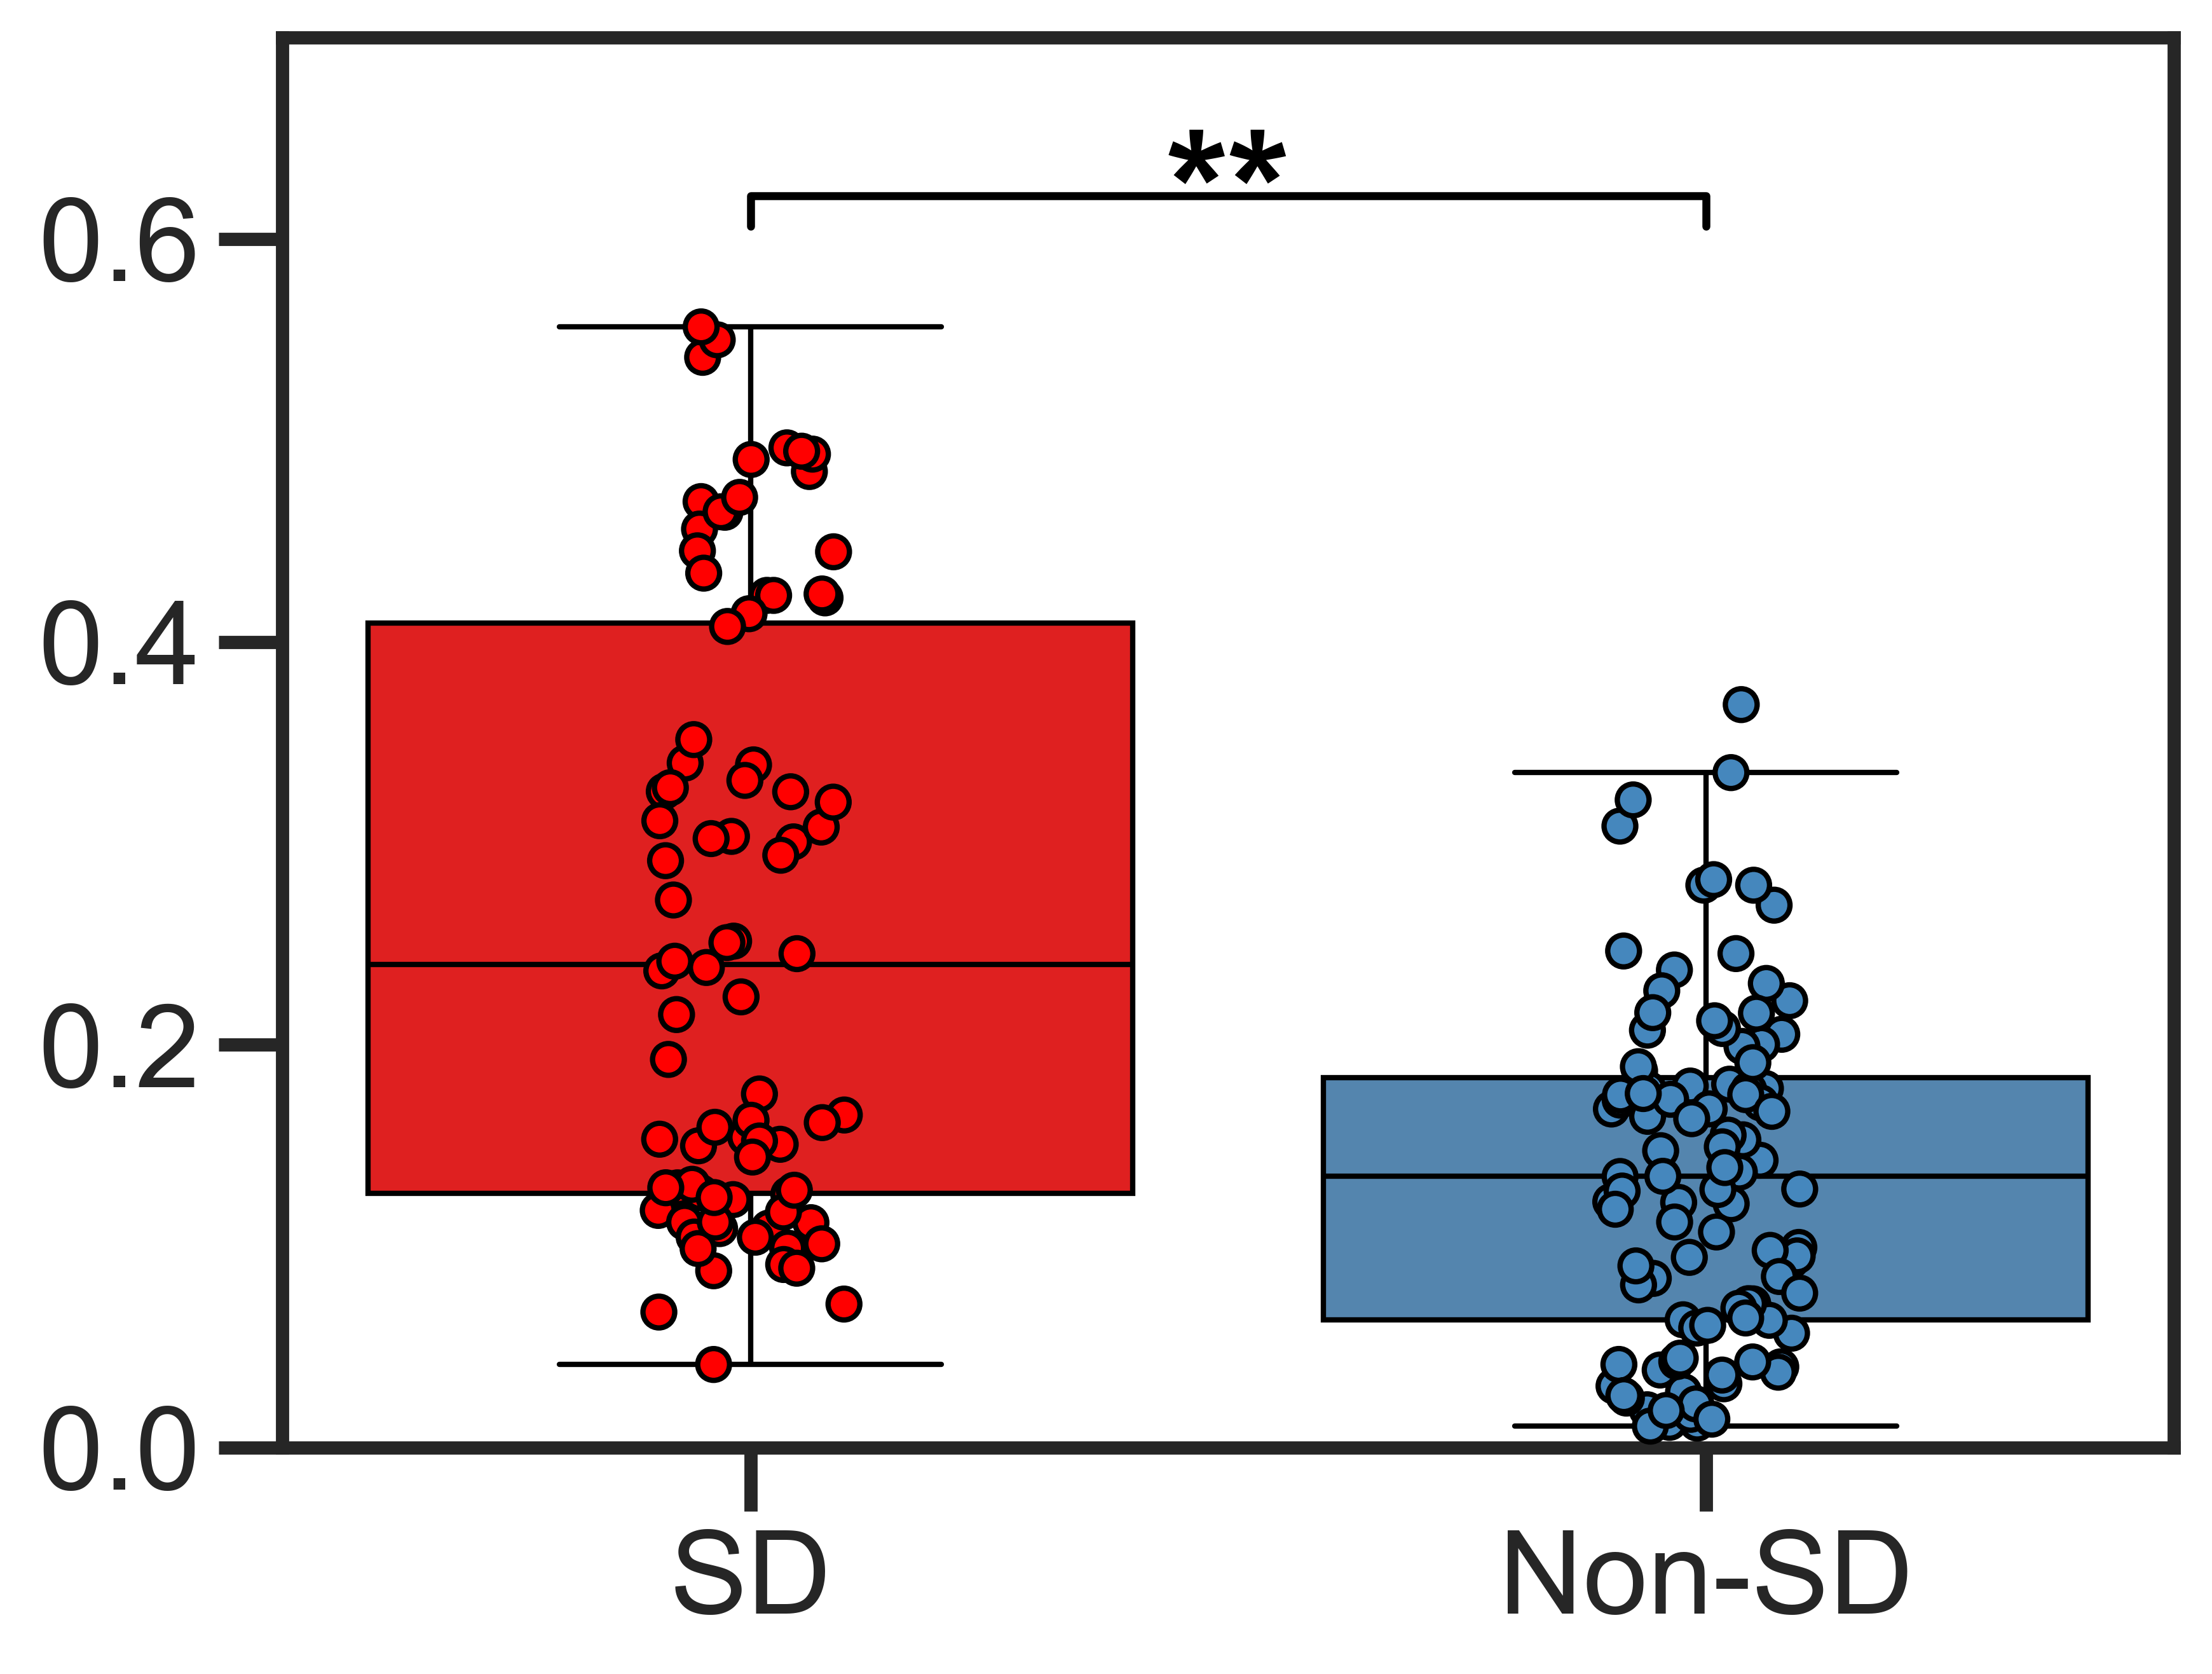

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming `results_LFP_total` is already defined and structured

# Map IntervalType to custom labels and colors
results_LFP_total['Group'] = results_LFP_total['IntervalType'].map({
    'status': 'SD', 
    'oneYear': 'Non-SD'
})

sns.set_style("ticks")
sns.set_context("poster")

ax = sns.boxplot(
    x='Group', 
    y='BetaPower', 
    data=results_LFP_total, 
    palette={'SD': 'red', 'Non-SD': '#4587BD'}, #
    showfliers=False,
    boxprops=dict(edgecolor='black'),  # Black outline for boxes
    whiskerprops=dict(color='black'),  # Black whiskers
    capprops=dict(color='black'),  # Black caps on whiskers
    medianprops=dict(color='black')  # Black median line
)

sns.stripplot(
    x='Group', 
    y='BetaPower', 
    data=results_LFP_total,
    palette={'SD': 'red', 'Non-SD': '#4587BD'},
    size=6,  # Adjust size of data points
    jitter=True,  # Disable jitter for midline alignment
    alpha=1,  # Make points fully opaque
    edgecolor='black',  # Add solid black outline
    linewidth=1,  # Width of the outline
    dodge=False,  # Ensure alignment with box midline
    ax=ax
)


# Calculate mean and standard deviation for each group
means = results_LFP_total.groupby('Group')['BetaPower'].mean()
std_devs = results_LFP_total.groupby('Group')['BetaPower'].std()
print(means)

# Add significance line and stars
x1, x2 = 0, 1  # Positions of the two groups
y, h, col = results_LFP_total['BetaPower'].max() + 0.05, 0.015, 'black'  # Adjust height (y, h)
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h-0.04, "**", ha='center', va='bottom', color=col, fontsize=30, weight='bold')

plt.ylim(0,0.7)
ax.set(xlabel=None)
ax.set(ylabel=None)
plt.show()


In [60]:
power_bands = ['BetaPower', 'AlphaPower', 'ThetaPower', 'DeltaPower', 'GammaPower']

# Dictionary to store the results
final_results = {}

# Perform the calculations for each power band
for power_band in power_bands:
    # Group data by IntervalType
    status_group = results_LFP_total[results_LFP_total['IntervalType'] == 'status'][power_band]
    one_year_group = results_LFP_total[results_LFP_total['IntervalType'] == 'oneYear'][power_band]

    # Calculate mean and standard deviation for each group
    status_mean = status_group.mean()
    status_std = status_group.std()
    one_year_mean = one_year_group.mean()
    one_year_std = one_year_group.std()
    
    # Perform Mann-Whitney U-test
    stat, p_value = mannwhitneyu(status_group, one_year_group)
    
    # Store the results
    final_results[power_band] = {
        'status_mean': status_mean,
        'status_std': status_std,
        'oneYear_mean': one_year_mean,
        'oneYear_std': one_year_std,
        'p_value': p_value,
        'stat': stat
    }

status_beta = results_LFP_total[results_LFP_total['IntervalType'] == 'status']['BetaPower']
status_beta_dbs005 = results_LFP_total[(results_LFP_total['IntervalType'] == 'status') & (results_LFP_total['Patient'] == 'DBS005')]['BetaPower']
status_beta_dbs014 = results_LFP_total[(results_LFP_total['IntervalType'] == 'status') & (results_LFP_total['Patient'] == 'DBS014')]['BetaPower']
status_beta_dbs018 = results_LFP_total[(results_LFP_total['IntervalType'] == 'status') & (results_LFP_total['Patient'] == 'DBS018')]['BetaPower']
status_beta_dbs005_mean = status_beta_dbs005.mean()
status_beta_dbs005_std = status_beta_dbs005.std()
status_beta_dbs014_mean = status_beta_dbs014.mean()
status_beta_dbs014_std = status_beta_dbs014.std()
status_beta_dbs018_mean = status_beta_dbs018.mean()
status_beta_dbs018_std = status_beta_dbs018.std()
print(f"Mean Beta Power for DBS005: {status_beta_dbs005_mean}")
print(f"Mean Beta Power for DBS014: {status_beta_dbs014_mean}")
print(f"Mean Beta Power for DBS018: {status_beta_dbs018_mean}")
print(f"Standard Deviation of Beta Power for DBS005: {status_beta_dbs005_std}")
print(f"Standard Deviation of Beta Power for DBS014: {status_beta_dbs014_std}")
print(f"Standard Deviation of Beta Power for DBS018: {status_beta_dbs018_std}")

# Convert the results to a DataFrame for better display
results_df = pd.DataFrame(final_results).T

# Display the final results
print(results_df)

Mean Beta Power for DBS005: 0.08310520221596791
Mean Beta Power for DBS014: 0.23635387676556663
Mean Beta Power for DBS018: 0.14550514580792392
Standard Deviation of Beta Power for DBS005: 0.03039198339400401
Standard Deviation of Beta Power for DBS014: 0.11209891537356283
Standard Deviation of Beta Power for DBS018: 0.06198228159305437
            status_mean  status_std  oneYear_mean  oneYear_std       p_value  \
BetaPower      0.218567    0.136191      0.152619     0.100211  6.975056e-06   
AlphaPower     0.104749    0.042325      0.105885     0.050592  9.441042e-01   
ThetaPower     0.191246    0.063397      0.213141     0.058528  1.689577e-04   
DeltaPower     0.259249    0.096859      0.310589     0.104489  5.004871e-05   
GammaPower     0.059491    0.033669      0.039156     0.031311  1.114777e-09   

               stat  
BetaPower   21848.0  
AlphaPower  17127.0  
ThetaPower  13310.0  
DeltaPower  13006.0  
GammaPower  23500.0  


In [38]:
#CORRECTED P-VALUES FOR MULTIPLE COMPARISONS
from statsmodels.stats.multitest import multipletests

# Extract p-values for correction
p_values = [final_results[power_band]['p_value'] for power_band in power_bands]

# Apply Bonferroni correction
_, p_corrected_bonferroni, _, _ = multipletests(p_values, method='bonferroni')

# Apply Benjamini-Hochberg (FDR) correction
_, p_corrected_bh, _, _ = multipletests(p_values, method='fdr_bh')

# Update final_results with corrected p-values
for i, power_band in enumerate(power_bands):
    final_results[power_band]['p_corrected_bonferroni'] = p_corrected_bonferroni[i]
    final_results[power_band]['p_corrected_bh'] = p_corrected_bh[i]

# Convert the updated results to a DataFrame for better display
results_df = pd.DataFrame(final_results).T

# Display the results
print(results_df)


            status_mean  status_std  oneYear_mean  oneYear_std       p_value  \
BetaPower      0.260680    0.146906      0.134256     0.083833  1.632112e-08   
AlphaPower     0.104601    0.034668      0.098131     0.052673  6.004165e-02   
ThetaPower     0.182835    0.071361      0.215422     0.061470  4.918922e-04   
DeltaPower     0.226418    0.086255      0.324212     0.102490  1.298442e-08   
GammaPower     0.071293    0.037462      0.037860     0.035353  4.935188e-10   

              stat  p_corrected_bonferroni  p_corrected_bh  
BetaPower   6175.0            8.160562e-08    2.720187e-08  
AlphaPower  4830.0            3.002082e-01    6.004165e-02  
ThetaPower  2913.0            2.459461e-03    6.148653e-04  
DeltaPower  2127.0            6.492209e-08    2.720187e-08  
GammaPower  6380.0            2.467594e-09    2.467594e-09  


In [39]:
#CORRECT FOR MULTIPLE SD EPISODES AND REPEATED MEASURES TEST
import pandas as pd
from statsmodels.formula.api import mixedlm
from statsmodels.stats.multitest import multipletests

sd_episodes_df = pd.read_csv(SD_episodesnumFile)

# Convert RecordingStartTime to datetime format in both dataframes
results_LFP_total['RecordingStartTime'] = pd.to_datetime(results_LFP_total['RecordingStartTime'])
sd_episodes_df['RecordingStartTime'] = pd.to_datetime(sd_episodes_df['RecordingStartTime'])

# Truncate seconds in results_LFP_total to match sd_episodes_df format
results_LFP_total['RecordingStartTime'] = results_LFP_total['RecordingStartTime'].dt.floor('T')

# Check for mismatched rows in each dataframe
results_mismatch = results_LFP_total[
    ~results_LFP_total[['Patient', 'IntervalType', 'RecordingStartTime']].isin(
        sd_episodes_df[['Patient', 'IntervalType', 'RecordingStartTime']].to_dict(orient='list')
    ).all(axis=1)
]

sd_episodes_mismatch = sd_episodes_df[
    ~sd_episodes_df[['Patient', 'IntervalType', 'RecordingStartTime']].isin(
        results_LFP_total[['Patient', 'IntervalType', 'RecordingStartTime']].to_dict(orient='list')
    ).all(axis=1)
]

# Display mismatches
print("Rows in results_LFP_total not in sd_episodes_df:")
print(results_mismatch)
print("\nRows in sd_episodes_df not in results_LFP_total:")
print(sd_episodes_mismatch)

# Align the dataframes by removing mismatched rows
aligned_results_LFP_total = results_LFP_total.merge(
    sd_episodes_df[['Patient', 'IntervalType', 'RecordingStartTime']],
    on=['Patient', 'IntervalType', 'RecordingStartTime'],
    how='inner'
)

aligned_sd_episodes_df = sd_episodes_df.merge(
    results_LFP_total[['Patient', 'IntervalType', 'RecordingStartTime']],
    on=['Patient', 'IntervalType', 'RecordingStartTime'],
    how='inner'
)

# Perform the final merge with aligned dataframes
merged_df = aligned_results_LFP_total.merge(
    sd_episodes_df[['Patient', 'IntervalType', 'RecordingStartTime', 'SDEpisodeNum']],
    on=['Patient', 'IntervalType', 'RecordingStartTime'],
    how='inner'
)

# Check the lengths of aligned dataframes
print(f"Aligned results_LFP_total length: {len(aligned_results_LFP_total)}")
print(f"Aligned sd_episodes_df length: {len(aligned_sd_episodes_df)}")
print(f"Merged dataframe length: {len(merged_df)}")

# Perform repeated measures analysis for BetaPower
print("Analyzing BetaPower...")

# Prepare data for BetaPower with both IntervalType and SDEpisodeNum
model_data = merged_df[['Patient', 'SDEpisodeNum', 'IntervalType', 'BetaPower']].dropna()

# Encode IntervalType as a categorical variable (status = 1, oneYear = 0)
model_data['IntervalType'] = model_data['IntervalType'].map({'status': 1, 'oneYear': 0})

# Fit the linear mixed-effects model
# Random effects for Patient and SDEpisodeNum
model = mixedlm(
    "BetaPower ~ IntervalType",  # IntervalType as the fixed effect
    data=model_data, 
    groups=model_data['Patient'],  # Random effect for Patient
    re_formula="~SDEpisodeNum"  # Random slope for SDEpisodeNum
)
result = model.fit()

print(result.summary())

# Extract the summary statistics
status_vs_oneyear_results = {
    'coef': result.params['IntervalType'],  # Effect size for IntervalType
    'p_value': result.pvalues['IntervalType'],  # P-value for IntervalType
    'ci_lower': result.conf_int().loc['IntervalType', 0],  # Lower bound of 95% CI
    'ci_upper': result.conf_int().loc['IntervalType', 1],  # Upper bound of 95% CI
}

# Create a DataFrame for better display
status_vs_oneyear_results_df = pd.DataFrame([status_vs_oneyear_results], index=['BetaPower'])

# Display the final results
print("\nFinal Results for BetaPower (Status vs. OneYear):")
print(status_vs_oneyear_results_df)

Rows in results_LFP_total not in sd_episodes_df:
    Patient Implant date StatusDysStart   Discharge  RecordingStartTime  \
245  DBS050   2024-01-08     2023-12-02  2000-01-01 2024-01-09 20:02:00   
250  DBS050   2024-01-08     2023-12-02  2000-01-01 2024-01-17 20:18:00   
253  DBS050   2024-01-08     2023-12-02  2000-01-01 2024-05-08 01:55:00   
255  DBS050   2024-01-08     2023-12-02  2000-01-01 2024-05-08 03:00:00   
257  DBS050   2024-01-08     2023-12-02  2000-01-01 2024-05-08 04:02:00   
259  DBS050   2024-01-08     2023-12-02  2000-01-01 2024-05-08 05:01:00   
261  DBS050   2024-01-08     2023-12-02  2000-01-01 2024-05-08 06:03:00   
263  DBS050   2024-01-08     2023-12-02  2000-01-01 2024-05-08 07:03:00   
265  DBS050   2024-01-08     2023-12-02  2000-01-01 2024-05-08 08:02:00   
267  DBS050   2024-01-08     2023-12-02  2000-01-01 2024-05-08 09:01:00   
269  DBS050   2024-01-08     2023-12-02  2000-01-01 2024-05-08 18:53:00   

    IntervalType RecordingType        Channel  Del

/var/folders/qr/d2wxfs456fsf5lgfshrqbsmw0000gn/T/ipykernel_12346/1561690269.py:13: FutureWarning:

'T' is deprecated and will be removed in a future version, please use 'min' instead.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning:

The MLE may be on the boundary of the parameter space.



In [40]:
#GLM TO SEE IF BETA POWER ASSOCIATED WITH BENZO OR OTHER-SEDATING:
# CORRECT FOR MULTIPLE SD EPISODES AND REPEATED MEASURES TEST
import pandas as pd
from statsmodels.formula.api import mixedlm

# Read SD episodes data
sd_episodes_df = pd.read_csv(SD_episodesnumFile)

# Convert RecordingStartTime to datetime format in both dataframes
results_LFP_total['RecordingStartTime'] = pd.to_datetime(results_LFP_total['RecordingStartTime'])
sd_episodes_df['RecordingStartTime'] = pd.to_datetime(sd_episodes_df['RecordingStartTime'])

# Truncate seconds in results_LFP_total to match sd_episodes_df format
results_LFP_total['RecordingStartTime'] = results_LFP_total['RecordingStartTime'].dt.floor('T')

# Check for mismatched rows in each dataframe
results_mismatch = results_LFP_total[
    ~results_LFP_total[['Patient', 'IntervalType', 'RecordingStartTime']].isin(
        sd_episodes_df[['Patient', 'IntervalType', 'RecordingStartTime']].to_dict(orient='list')
    ).all(axis=1)
]

sd_episodes_mismatch = sd_episodes_df[
    ~sd_episodes_df[['Patient', 'IntervalType', 'RecordingStartTime']].isin(
        results_LFP_total[['Patient', 'IntervalType', 'RecordingStartTime']].to_dict(orient='list')
    ).all(axis=1)
]

# Display mismatches
print("Rows in results_LFP_total not in sd_episodes_df:")
print(results_mismatch)
print("\nRows in sd_episodes_df not in results_LFP_total:")
print(sd_episodes_mismatch)

# Align the dataframes by removing mismatched rows
aligned_results_LFP_total = results_LFP_total.merge(
    sd_episodes_df[['Patient', 'IntervalType', 'RecordingStartTime', 'Benzo', 'OtherSedating']],
    on=['Patient', 'IntervalType', 'RecordingStartTime'],
    how='inner'
)

aligned_sd_episodes_df = sd_episodes_df.merge(
    results_LFP_total[['Patient', 'IntervalType', 'RecordingStartTime']],
    on=['Patient', 'IntervalType', 'RecordingStartTime'],
    how='inner'
)

# Perform the final merge with aligned dataframes
merged_df = aligned_results_LFP_total.merge(
    sd_episodes_df[['Patient', 'IntervalType', 'RecordingStartTime', 'SDEpisodeNum']],
    on=['Patient', 'IntervalType', 'RecordingStartTime'],
    how='inner'
)

# Check the lengths of aligned dataframes
print(f"Aligned results_LFP_total length: {len(aligned_results_LFP_total)}")
print(f"Aligned sd_episodes_df length: {len(aligned_sd_episodes_df)}")
print(f"Merged dataframe length: {len(merged_df)}")

# Prepare data for BetaPower analysis
print("Analyzing BetaPower...")

# Prepare data for BetaPower with Benzo and OtherSedating
model_data = merged_df[['Patient', 'SDEpisodeNum', 'Benzo', 'OtherSedating', 'BetaPower']].dropna()

# Encode Benzo and OtherSedating as binary variables (Y = 1, N = 0)
model_data['Benzo'] = model_data['Benzo'].map({'Y': 1, 'N': 0})
model_data['OtherSedating'] = model_data['OtherSedating'].map({'Y': 1, 'N': 0})

# Fit the linear mixed-effects model
# Random effects for Patient and SDEpisodeNum
model = mixedlm(
    "BetaPower ~ Benzo + OtherSedating",  # Benzo and OtherSedating as fixed effects
    data=model_data, 
    groups=model_data['Patient'],  # Random effect for Patient
    re_formula="~SDEpisodeNum"  # Random slope for SDEpisodeNum
)
result = model.fit()

# Print the summary
print(result.summary())

# Extract the summary statistics
benzo_sedation_results = {
    'Benzo_coef': result.params['Benzo'],  # Effect size for Benzo
    'Benzo_p_value': result.pvalues['Benzo'],  # P-value for Benzo
    'Benzo_ci_lower': result.conf_int().loc['Benzo', 0],  # Lower bound of 95% CI for Benzo
    'Benzo_ci_upper': result.conf_int().loc['Benzo', 1],  # Upper bound of 95% CI for Benzo
    'OtherSedating_coef': result.params['OtherSedating'],  # Effect size for OtherSedating
    'OtherSedating_p_value': result.pvalues['OtherSedating'],  # P-value for OtherSedating
    'OtherSedating_ci_lower': result.conf_int().loc['OtherSedating', 0],  # Lower bound of 95% CI for OtherSedating
    'OtherSedating_ci_upper': result.conf_int().loc['OtherSedating', 1],  # Upper bound of 95% CI for OtherSedating
}

# Create a DataFrame for better display
benzo_sedation_results_df = pd.DataFrame([benzo_sedation_results], index=['BetaPower'])

# Display the final results
print("\nFinal Results for BetaPower (Effect of Benzo and OtherSedating):")
print(benzo_sedation_results_df)


Rows in results_LFP_total not in sd_episodes_df:
    Patient Implant date StatusDysStart   Discharge  RecordingStartTime  \
245  DBS050   2024-01-08     2023-12-02  2000-01-01 2024-01-09 20:02:00   
250  DBS050   2024-01-08     2023-12-02  2000-01-01 2024-01-17 20:18:00   
253  DBS050   2024-01-08     2023-12-02  2000-01-01 2024-05-08 01:55:00   
255  DBS050   2024-01-08     2023-12-02  2000-01-01 2024-05-08 03:00:00   
257  DBS050   2024-01-08     2023-12-02  2000-01-01 2024-05-08 04:02:00   
259  DBS050   2024-01-08     2023-12-02  2000-01-01 2024-05-08 05:01:00   
261  DBS050   2024-01-08     2023-12-02  2000-01-01 2024-05-08 06:03:00   
263  DBS050   2024-01-08     2023-12-02  2000-01-01 2024-05-08 07:03:00   
265  DBS050   2024-01-08     2023-12-02  2000-01-01 2024-05-08 08:02:00   
267  DBS050   2024-01-08     2023-12-02  2000-01-01 2024-05-08 09:01:00   
269  DBS050   2024-01-08     2023-12-02  2000-01-01 2024-05-08 18:53:00   

    IntervalType RecordingType        Channel  Del

/var/folders/qr/d2wxfs456fsf5lgfshrqbsmw0000gn/T/ipykernel_12346/1006208809.py:14: FutureWarning:

'T' is deprecated and will be removed in a future version, please use 'min' instead.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning:

The MLE may be on the boundary of the parameter space.



In [9]:
from scipy.stats import mannwhitneyu
import pandas as pd

phenom_df = pd.read_csv(phenomenologyFile)

# Ensure the column 'Patient' in `phenom_df` aligns with `results_LFP_total`
merged_df = results_LFP_total.merge(phenom_df, on='Patient', how='inner')

# Define power bands
power_bands = ['BetaPower', 'AlphaPower', 'ThetaPower', 'DeltaPower', 'GammaPower']

# Dictionary to store the results
final_results = {}

# Perform the calculations for each group ('status' and 'oneYear')
for interval_type in ['status', 'oneYear']:
    # Filter data for the specific IntervalType
    interval_df = merged_df[merged_df['IntervalType'] == interval_type]
    
    # Initialize a nested dictionary to store results for this IntervalType
    final_results[interval_type] = {}
    
    for power_band in power_bands:
        # Group data by whether 'Phenomenology' is 'Tonic' or not
        tonic_group = interval_df[interval_df['Phenomenology'] == 'Tonic'][power_band]
        non_tonic_group = interval_df[interval_df['Phenomenology'] != 'Tonic'][power_band]
        
        # Calculate mean and standard deviation for each group
        tonic_mean = tonic_group.mean()
        tonic_std = tonic_group.std()
        non_tonic_mean = non_tonic_group.mean()
        non_tonic_std = non_tonic_group.std()
        
        # Perform Mann-Whitney U-test
        stat, p_value = mannwhitneyu(tonic_group, non_tonic_group)
        
        # Store the results
        final_results[interval_type][power_band] = {
            'tonic_mean': tonic_mean,
            'tonic_std': tonic_std,
            'non_tonic_mean': non_tonic_mean,
            'non_tonic_std': non_tonic_std,
            'p_value': p_value,
            'stat': stat
        }

# Convert the results to a DataFrame for better display
status_results_df = pd.DataFrame(final_results['status']).T
one_year_results_df = pd.DataFrame(final_results['oneYear']).T

# Display the final results for both 'status' and 'oneYear'
print("Results for 'status':")
print(status_results_df)

print("\nResults for 'oneYear':")
print(one_year_results_df)


Results for 'status':
            tonic_mean  tonic_std  non_tonic_mean  non_tonic_std   p_value  \
BetaPower     0.240960   0.135275        0.406606       0.154084  0.002118   
AlphaPower    0.099222   0.032006        0.144406       0.027867  0.000232   
ThetaPower    0.184502   0.069736        0.170501       0.085595  0.427076   
DeltaPower    0.237645   0.081564        0.143336       0.077117  0.001088   
GammaPower    0.074390   0.038145        0.048368       0.021850  0.036388   

             stat  
BetaPower   147.0  
AlphaPower  103.0  
ThetaPower  428.0  
DeltaPower  607.0  
GammaPower  522.0  

Results for 'oneYear':
            tonic_mean  tonic_std  non_tonic_mean  non_tonic_std  \
BetaPower     0.115491   0.080312        0.196261       0.063891   
AlphaPower    0.084294   0.045566        0.143852       0.049333   
ThetaPower    0.214690   0.065956        0.217842       0.044649   
DeltaPower    0.351143   0.099369        0.235224       0.048430   
GammaPower    0.030782   

In [10]:
#INDIVIDUAL PATIENT STATS for LFP BANDS
results_LFP_total = pd.DataFrame()

# Initialize an empty list to store all the results
all_results = []

# Iterate over each patient and hemisphere
for patient in patList:
    for hemisphere in ['LEFT', 'RIGHT']:
        patientLFPDataFileName = os.path.join(resultsLFPPowersDir, f"{patient}_{hemisphere}_LFPpowers.csv")
        patient_LFP_df = pd.read_csv(patientLFPDataFileName)

        # Split the data based on the 'IntervalType' into two separate DataFrames
        status_LFP_df = patient_LFP_df[patient_LFP_df['IntervalType'] == 'status']
        oneyear_LFP_df = patient_LFP_df[patient_LFP_df['IntervalType'] == 'oneYear']

        # Skip if there is no 'oneYear' data
        if oneyear_LFP_df.shape[0] == 0:
            print(f"No post-status data for Patient: {patient} - Hemisphere: {hemisphere}")
            continue

        # Calculate statistics for each power band
        for column in ['DeltaPower', 'ThetaPower', 'AlphaPower', 'BetaPower', 'GammaPower']:
            status_mean = status_LFP_df[column].mean()
            status_median = status_LFP_df[column].median()
            status_std = status_LFP_df[column].std()
            status_sem = sem(status_LFP_df[column].dropna())  # Standard error of the mean

            one_year_mean = oneyear_LFP_df[column].mean()
            one_year_median = oneyear_LFP_df[column].median()
            one_year_std = oneyear_LFP_df[column].std()
            one_year_sem = sem(oneyear_LFP_df[column].dropna())  # Standard error of the mean

            # Mann-Whitney U test
            u_stat, p_value = mannwhitneyu(status_LFP_df[column].dropna(), oneyear_LFP_df[column].dropna(), alternative='two-sided')

            # Append the results for each power band to the all_results list
            all_results.append([patient, hemisphere, column, 'Status', status_mean, status_median, status_std, status_sem, p_value, u_stat])
            all_results.append([patient, hemisphere, column, 'OneYear', one_year_mean, one_year_median, one_year_std, one_year_sem, p_value, u_stat])

# Convert the results into a DataFrame
results_df = pd.DataFrame(all_results, columns=['Patient', 'Hemisphere', 'Power Band', 'IntervalType', 'Mean', 'Median', 'Standard Deviation', 'Standard Error', 'P-value', 'U-stat'])

#print(results_df)
beta_power_df = results_df[results_df['Power Band'] == 'BetaPower']

# Display the filtered DataFrame
print(beta_power_df)

from IPython.display import display, HTML

# Filter the DataFrame
beta_power_df = results_df[results_df['Power Band'] == 'BetaPower']

# Display as HTML table
display(HTML(beta_power_df.to_html(index=False)))


No post-status data for Patient: DBS005 - Hemisphere: LEFT
No post-status data for Patient: DBS005 - Hemisphere: RIGHT
No post-status data for Patient: DBS014 - Hemisphere: LEFT
No post-status data for Patient: DBS014 - Hemisphere: RIGHT
No post-status data for Patient: DBS018 - Hemisphere: LEFT
No post-status data for Patient: DBS018 - Hemisphere: RIGHT
    Patient Hemisphere Power Band IntervalType      Mean    Median  \
6    DBS003       LEFT  BetaPower       Status  0.189932  0.195574   
7    DBS003       LEFT  BetaPower      OneYear  0.189099  0.175830   
16   DBS003      RIGHT  BetaPower       Status  0.358181  0.376929   
17   DBS003      RIGHT  BetaPower      OneYear  0.219762  0.237111   
26   DBS013       LEFT  BetaPower       Status  0.150638  0.141268   
27   DBS013       LEFT  BetaPower      OneYear  0.145291  0.137534   
36   DBS013      RIGHT  BetaPower       Status  0.290215  0.288448   
37   DBS013      RIGHT  BetaPower      OneYear  0.188296  0.189326   
46   DBS021  

Patient,Hemisphere,Power Band,IntervalType,Mean,Median,Standard Deviation,Standard Error,P-value,U-stat
DBS003,LEFT,BetaPower,Status,0.189932,0.195574,0.078859,0.016097,5.350220e-01,189.0
DBS003,LEFT,BetaPower,OneYear,0.189099,0.175830,0.083003,0.022183,5.350220e-01,189.0
DBS003,RIGHT,BetaPower,Status,0.358181,0.376929,0.109729,0.022398,9.920431e-04,260.0
DBS003,RIGHT,BetaPower,OneYear,0.219762,0.237111,0.080189,0.022240,9.920431e-04,260.0
DBS013,LEFT,BetaPower,Status,0.150638,0.141268,0.097063,0.048532,9.670540e-01,35.0
DBS013,LEFT,BetaPower,OneYear,0.145291,0.137534,0.041258,0.009725,9.670540e-01,35.0
DBS013,RIGHT,BetaPower,Status,0.290215,0.288448,0.160279,0.080139,7.119617e-01,41.0
DBS013,RIGHT,BetaPower,OneYear,0.188296,0.189326,0.063567,0.014983,7.119617e-01,41.0
DBS021,LEFT,BetaPower,Status,0.217093,0.195514,0.088893,0.023758,6.139388e-03,107.0
DBS021,LEFT,BetaPower,OneYear,0.132209,0.137745,0.030002,0.010001,6.139388e-03,107.0


In [65]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind, mannwhitneyu
import os
import glob

# Initialize lists to store data for each patient and for global comparison
all_patients_data = []
DBS005_data = [] #for the 3 patients without non-SD data
DBS014_data = []
DBS018_data = []
global_status_data = { 'Peak CF': [], 'Peak PW': [], 'Peak BW': [], 'Aperiodic Offset': [], 'Aperiodic Exponent': [] , 'Peak PW linear': []}
global_oneYear_data = { 'Peak CF': [], 'Peak PW': [], 'Peak BW': [], 'Aperiodic Offset': [], 'Aperiodic Exponent': [], 'Peak PW linear': []}

# Criteria for hemisphere exclusion
exclude_hemisphere_conditions = [
    ('DBS003', 'LEFT'), ('DBS021', 'LEFT'), ('DBS013', 'LEFT'), ('DBS005', 'LEFT'),
    ('DBS014', 'RIGHT'), ('DBS036', 'LEFT'), ('DBS047', 'RIGHT'), 
    ('DBS050', 'RIGHT'), ('DBS039', 'RIGHT'), ('DBS018', 'RIGHT'),
    ('DBS009', 'RIGHT'), ('DBS009', 'LEFT')
]

# Iterate through each patient's peak data files in the directory
for peak_file in glob.glob(os.path.join(resultsPSDPeaksDir, "*_PSDPeaks.csv")):
    patient_peak_df = pd.read_csv(peak_file)
    
    # Extract patient identifier and hemisphere from the filename
    file_name_parts = os.path.basename(peak_file).split('_')
    patient = file_name_parts[0]
    hemisphere = file_name_parts[1]
    
    # Determine if this hemisphere should be included in the global comparison
    if (patient, hemisphere) in exclude_hemisphere_conditions:
        print(f"Skipping {hemisphere} hemisphere for patient {patient} in global comparison.")
        continue

    # Filter data by status and oneYear
    status_data = patient_peak_df[patient_peak_df['IntervalType'] == 'status']
    oneYear_data = patient_peak_df[patient_peak_df['IntervalType'] == 'oneYear']

    #Add linear peak power, converting Peak PW to linear scale
    status_data['Peak PW linear'] = 10 ** status_data['Peak PW']
    oneYear_data['Peak PW linear'] = 10 ** oneYear_data['Peak PW']
    
    '''
    if status_data.empty or oneYear_data.empty:
        print(f"Insufficient data for patient {patient}, hemisphere {hemisphere}")
        continue
    '''
    
    # List of parameters to compare
    params = ['Peak CF', 'Peak PW', 'Peak BW', 'Aperiodic Offset', 'Aperiodic Exponent', 'Peak PW linear']
    
    # Calculate statistics for each parameter
    patient_stats = {'Patient': patient, 'Hemisphere': hemisphere}
    for param in params:
        if patient == 'DBS005': #no non-SD data, so store the SD data for later
            DBS005_data.append(status_data[param].dropna().tolist())
        if patient == 'DBS014':
            DBS014_data.append(status_data[param].dropna().tolist())
        if patient == 'DBS018':
            DBS018_data.append(status_data[param].dropna().tolist())
        
        if oneYear_data.empty:
            continue
        global_status_data[param].extend(status_data[param].dropna().tolist())
        global_oneYear_data[param].extend(oneYear_data[param].dropna().tolist())

        # Calculate mean, standard deviation for each group
        mean_status = status_data[param].mean()
        std_status = status_data[param].std()
        mean_oneYear = oneYear_data[param].mean()
        std_oneYear = oneYear_data[param].std()
        
        # Perform parametric t-test
        t_stat, p_value_ttest = ttest_ind(status_data[param], oneYear_data[param], nan_policy='omit')
        
        # Perform non-parametric Mann-Whitney U test
        try:
            u_stat, p_value_mannwhitney = mannwhitneyu(status_data[param], oneYear_data[param], alternative='two-sided')
        except ValueError:
            u_stat, p_value_mannwhitney = np.nan, np.nan
        
        # Store results for patient comparison
        patient_stats[f"{param}_status_mean"] = mean_status
        patient_stats[f"{param}_status_std"] = std_status
        patient_stats[f"{param}_oneYear_mean"] = mean_oneYear
        patient_stats[f"{param}_oneYear_std"] = std_oneYear
        patient_stats[f"{param}_p_value_ttest"] = p_value_ttest
        patient_stats[f"{param}_t_statistic"] = t_stat
        patient_stats[f"{param}_p_value_mannwhitney"] = p_value_mannwhitney
        patient_stats[f"{param}_u_statistic"] = u_stat
        
        '''
        # Append data to global lists for cross-patient comparison (only if the hemisphere is included)
        global_status_data[param].extend(status_data[param].dropna().tolist())
        global_oneYear_data[param].extend(oneYear_data[param].dropna().tolist())
        '''
        
    if status_data.empty or oneYear_data.empty:
        print(f"Insufficient data for patient {patient}, hemisphere {hemisphere}")
        continue
    
    # Append patient statistics to the list
    all_patients_data.append(patient_stats)

# Convert the list of all patient data to a DataFrame for easier analysis across patients
all_patients_df = pd.DataFrame(all_patients_data)

# Perform cross-patient comparisons for each parameter using only selected hemispheres
global_comparison_data = []
for param in params:
    # Calculate means and standard deviations across all patients for each recording type
    global_mean_status = np.mean(global_status_data[param])
    global_std_status = np.std(global_status_data[param], ddof=1)
    global_mean_oneYear = np.mean(global_oneYear_data[param])
    global_std_oneYear = np.std(global_oneYear_data[param], ddof=1)
    
    # Perform parametric t-test
    t_stat, global_p_value_ttest = ttest_ind(global_status_data[param], global_oneYear_data[param], nan_policy='omit')
    
    # Perform non-parametric Mann-Whitney U test
    try:
        u_stat, global_p_value_mannwhitney = mannwhitneyu(global_status_data[param], global_oneYear_data[param], alternative='two-sided')
    except ValueError:
        u_stat, global_p_value_mannwhitney = np.nan, np.nan
    
    # Store results for global comparison
    global_comparison_data.append({
        'Parameter': param,
        'Global Status Mean': global_mean_status,
        'Global Status Std': global_std_status,
        'Global OneYear Mean': global_mean_oneYear,
        'Global OneYear Std': global_std_oneYear,
        'Global p-value (t-test)': global_p_value_ttest,
        'Global t-statistic': t_stat,
        'Global p-value (Mann-Whitney U)': global_p_value_mannwhitney,
        'Global u-statistic': u_stat
    })

# Convert global comparison data to DataFrame
global_comparison_df = pd.DataFrame(global_comparison_data)

import pandas as pd
from IPython.display import display 
print("Patient-wise Comparison Data:")
display(all_patients_df)

#Display just the columns Patient, Peak_PW_p_value_mannwhitney and Peak_PW_u_statistic from all_patients_df
display(all_patients_df[['Patient', 'Peak PW_p_value_mannwhitney', 'Peak PW_u_statistic','Peak PW linear_p_value_mannwhitney', 'Peak PW linear_u_statistic']])

print("\nGlobal Comparison Data:")
display(global_comparison_df)

#Calculate mean and standard deviation for Peak PW, Aperiodic Offset, Aperiodic Exponent in global_status_data for DBS005, DBS014 and DBS018
DBS005_status_peak_pw_mean = np.mean(DBS005_data[1])
DBS005_status_peak_pw_std = np.std(DBS005_data[1], ddof=1)
DBS005_status_aperiodic_offset_mean = np.mean(DBS005_data[3])
DBS005_status_aperiodic_offset_std = np.std(DBS005_data[3], ddof=1)
DBS005_status_aperiodic_exponent_mean = np.mean(DBS005_data[4])
DBS005_status_aperiodic_exponent_std = np.std(DBS005_data[4], ddof=1)

DBS014_status_peak_pw_mean = np.mean(DBS014_data[1])
DBS014_status_peak_pw_std = np.std(DBS014_data[1], ddof=1)
DBS014_status_aperiodic_offset_mean = np.mean(DBS014_data[3])
DBS014_status_aperiodic_offset_std = np.std(DBS014_data[3], ddof=1)
DBS014_status_aperiodic_exponent_mean = np.mean(DBS014_data[4])
DBS014_status_aperiodic_exponent_std = np.std(DBS014_data[4], ddof=1)

DBS018_status_peak_pw_mean = np.mean(DBS018_data[1])
DBS018_status_peak_pw_std = np.std(DBS018_data[1], ddof=1)
DBS018_status_aperiodic_offset_mean = np.mean(DBS018_data[3])
DBS018_status_aperiodic_offset_std = np.std(DBS018_data[3], ddof=1)
DBS018_status_aperiodic_exponent_mean = np.mean(DBS018_data[4])
DBS018_status_aperiodic_exponent_std = np.std(DBS018_data[4], ddof=1)

#display the mean and standard deviation for Peak PW, Aperiodic Offset, Aperiodic Exponent for DBS005, DBS014 and DBS018 in a table, using a dataframe
DBS_onlySD_stats = {
    'DBS005': [DBS005_status_peak_pw_mean, DBS005_status_peak_pw_std, DBS005_status_aperiodic_offset_mean, DBS005_status_aperiodic_offset_std, DBS005_status_aperiodic_exponent_mean, DBS005_status_aperiodic_exponent_std],
    'DBS014': [DBS014_status_peak_pw_mean, DBS014_status_peak_pw_std, DBS014_status_aperiodic_offset_mean, DBS014_status_aperiodic_offset_std, DBS014_status_aperiodic_exponent_mean, DBS014_status_aperiodic_exponent_std],
    'DBS018': [DBS018_status_peak_pw_mean, DBS018_status_peak_pw_std, DBS018_status_aperiodic_offset_mean, DBS018_status_aperiodic_offset_std, DBS018_status_aperiodic_exponent_mean, DBS018_status_aperiodic_exponent_std]
}
#make DBS_onlySD_stats into a dataframe
DBS_onlySD_stats_df = pd.DataFrame(DBS_onlySD_stats, index=['Peak PW Mean', 'Peak PW Std', 'Aperiodic Offset Mean', 'Aperiodic Offset Std', 'Aperiodic Exponent Mean', 'Aperiodic Exponent Std'])
display(DBS_onlySD_stats_df)



Skipping LEFT hemisphere for patient DBS005 in global comparison.
Skipping RIGHT hemisphere for patient DBS039 in global comparison.
Skipping RIGHT hemisphere for patient DBS047 in global comparison.
Insufficient data for patient DBS018, hemisphere LEFT
Skipping RIGHT hemisphere for patient DBS014 in global comparison.
Skipping RIGHT hemisphere for patient DBS009 in global comparison.
Skipping LEFT hemisphere for patient DBS036 in global comparison.
Skipping LEFT hemisphere for patient DBS003 in global comparison.
Skipping LEFT hemisphere for patient DBS013 in global comparison.
Skipping RIGHT hemisphere for patient DBS050 in global comparison.
Insufficient data for patient DBS014, hemisphere LEFT
Insufficient data for patient DBS005, hemisphere RIGHT
Skipping RIGHT hemisphere for patient DBS018 in global comparison.
Skipping LEFT hemisphere for patient DBS009 in global comparison.
Skipping LEFT hemisphere for patient DBS021 in global comparison.
Patient-wise Comparison Data:


/var/folders/qr/d2wxfs456fsf5lgfshrqbsmw0000gn/T/ipykernel_12346/3254232359.py:42: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/qr/d2wxfs456fsf5lgfshrqbsmw0000gn/T/ipykernel_12346/3254232359.py:43: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/qr/d2wxfs456fsf5lgfshrqbsmw0000gn/T/ipykernel_12346/3254232359.py:42: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

,Patient,Hemisphere,Peak CF_status_mean,Peak CF_status_std,Peak CF_oneYear_mean,Peak CF_oneYear_std,Peak CF_p_value_ttest,Peak CF_t_statistic,Peak CF_p_value_mannwhitney,Peak CF_u_statistic,...,Aperiodic Exponent_p_value_mannwhitney,Aperiodic Exponent_u_statistic,Peak PW linear_status_mean,Peak PW linear_status_std,Peak PW linear_oneYear_mean,Peak PW linear_oneYear_std,Peak PW linear_p_value_ttest,Peak PW linear_t_statistic,Peak PW linear_p_value_mannwhitney,Peak PW linear_u_statistic
0,DBS050,LEFT,35.363195,22.460194,14.360807,12.653175,0.004614,3.111326,0.084443,109.0,...,9.008705e-07,0.0,2.457857,1.208938,3.246307,1.022702,0.095013,-1.735231,0.039038,37.0
1,DBS021,RIGHT,18.443580,6.594827,16.393626,3.393454,0.437877,0.795657,0.633438,46.0,...,3.154166e-01,28.0,5.351633,1.605484,3.581845,0.279567,0.007439,3.062676,0.003062,72.0
2,DBS003,RIGHT,23.999650,7.355829,21.616695,6.882110,0.342901,0.961491,0.197580,197.0,...,6.525875e-03,70.0,4.590787,2.463415,2.537270,1.085297,0.007363,2.845514,0.002643,251.0
3,DBS013,RIGHT,15.824536,3.823462,20.940896,11.094376,0.381135,-0.895570,0.342037,24.0,...,9.670540e-01,35.0,3.897589,2.728492,3.678162,4.052709,0.919592,0.102230,0.967054,35.0
4,DBS039,LEFT,16.480240,3.637344,18.549519,18.443421,0.756448,-0.312589,0.624968,130.0,...,3.626190e-07,3.0,10.407234,6.730222,4.985141,3.012275,0.001889,3.361041,0.031921,174.0
5,DBS047,LEFT,31.763614,21.399805,36.016222,28.582429,0.747374,-0.329029,0.866511,30.0,...,6.216006e-04,1.0,2.570772,0.957178,2.187204,0.875914,0.435253,0.805076,0.335664,37.0
6,DBS036,RIGHT,16.298531,1.209744,14.813729,2.183355,0.185918,1.432093,0.246753,22.0,...,5.194805e-02,4.0,18.537485,4.042634,5.568339,1.760086,0.000097,6.623509,0.004329,30.0


,Patient,Peak PW_p_value_mannwhitney,Peak PW_u_statistic,Peak PW linear_p_value_mannwhitney,Peak PW linear_u_statistic
0,DBS050,0.039038,37.0,0.039038,37.0
1,DBS021,0.003062,72.0,0.003062,72.0
2,DBS003,0.002643,251.0,0.002643,251.0
3,DBS013,0.967054,35.0,0.967054,35.0
4,DBS039,0.031921,174.0,0.031921,174.0
5,DBS047,0.335664,37.0,0.335664,37.0
6,DBS036,0.004329,30.0,0.004329,30.0



Global Comparison Data:


,Parameter,Global Status Mean,Global Status Std,Global OneYear Mean,Global OneYear Std,Global p-value (t-test),Global t-statistic,Global p-value (Mann-Whitney U),Global u-statistic
0,Peak CF,23.387840,13.038754,19.455311,15.249114,8.464491e-02,1.734793,1.080249e-03,4370.0
1,Peak PW,0.653491,0.325945,0.511166,0.230737,1.165524e-03,3.304898,6.124190e-03,4208.0
2,Peak BW,6.308581,3.432390,5.275117,3.140778,4.591982e-02,2.011317,6.886666e-02,3925.0
3,Aperiodic Offset,-0.451346,0.330260,-0.166497,0.262334,4.429271e-09,-6.197287,3.279275e-09,1549.0
4,Aperiodic Exponent,1.444887,0.384975,1.839030,0.399950,1.980642e-09,-6.352436,3.917176e-09,1558.0
5,Peak PW linear,6.088197,5.412153,3.810578,2.644884,4.062208e-04,3.609705,6.124190e-03,4208.0


,DBS005,DBS014,DBS018
Peak PW Mean,0.452845,0.748814,0.413548
Peak PW Std,0.186975,0.097720,0.193628
Aperiodic Offset Mean,-0.607731,-0.067996,-0.243968
Aperiodic Offset Std,0.085733,0.163411,0.154816
Aperiodic Exponent Mean,1.370914,1.853822,1.607425
Aperiodic Exponent Std,0.114573,0.256157,0.204281


In [13]:
#Correct for multiple comparisons:
from statsmodels.stats.multitest import multipletests

# Correcting p-values in global comparison data
global_p_values_ttest = global_comparison_df['Global p-value (t-test)']
global_p_values_mannwhitney = global_comparison_df['Global p-value (Mann-Whitney U)']

# Apply multiple comparisons correction
_, corrected_p_ttest_global, _, _ = multipletests(global_p_values_ttest, method='bonferroni')
_, corrected_p_mannwhitney_global, _, _ = multipletests(global_p_values_mannwhitney, method='fdr_bh')

# Add corrected p-values to the global_comparison_df
global_comparison_df['Corrected p-value (t-test)'] = corrected_p_ttest_global
global_comparison_df['Corrected p-value (Mann-Whitney U)'] = corrected_p_mannwhitney_global

# Correcting p-values in patient-wise comparison data
for param in params:
    if f"{param}_p_value_mannwhitney" in all_patients_df.columns:
        # Extract patient-specific p-values for Mann-Whitney U
        patient_p_values = all_patients_df[f"{param}_p_value_mannwhitney"].dropna()
        
        # Apply multiple comparisons correction
        _, corrected_patient_p_values, _, _ = multipletests(patient_p_values, method='bonferroni')
        
        # Update patient-wise DataFrame with corrected p-values
        all_patients_df.loc[
            all_patients_df[f"{param}_p_value_mannwhitney"].notnull(), 
            f"{param}_corrected_p_value_mannwhitney"
        ] = corrected_patient_p_values

# Display updated global comparison data
print("\nCorrected Global Comparison Data:")
display(global_comparison_df)



Corrected Global Comparison Data:


,Parameter,Global Status Mean,Global Status Std,Global OneYear Mean,Global OneYear Std,Global p-value (t-test),Global t-statistic,Global p-value (Mann-Whitney U),Global u-statistic,Corrected p-value (t-test),Corrected p-value (Mann-Whitney U)
0,Peak CF,23.387840,13.038754,19.455311,15.249114,8.464491e-02,1.734793,1.080249e-03,4370.0,5.078695e-01,2.160497e-03
1,Peak PW,0.653491,0.325945,0.511166,0.230737,1.165524e-03,3.304898,6.124190e-03,4208.0,6.993146e-03,7.349028e-03
2,Peak BW,6.308581,3.432390,5.275117,3.140778,4.591982e-02,2.011317,6.886666e-02,3925.0,2.755189e-01,6.886666e-02
3,Aperiodic Offset,-0.451346,0.330260,-0.166497,0.262334,4.429271e-09,-6.197287,3.279275e-09,1549.0,2.657563e-08,1.175153e-08
4,Aperiodic Exponent,1.444887,0.384975,1.839030,0.399950,1.980642e-09,-6.352436,3.917176e-09,1558.0,1.188385e-08,1.175153e-08
5,Peak PW linear,6.088197,5.412153,3.810578,2.644884,4.062208e-04,3.609705,6.124190e-03,4208.0,2.437325e-03,7.349028e-03



Corrected Patient-wise Comparison Data:


,Patient,Peak PW_p_value_mannwhitney,Peak PW_corrected_p_value_mannwhitney,Peak PW_u_statistic,Peak PW linear_p_value_mannwhitney,Peak PW linear_corrected_p_value_mannwhitney,Peak PW linear_u_statistic
0,DBS050,0.039038,0.273268,37.0,0.039038,0.273268,37.0
1,DBS021,0.003062,0.021436,72.0,0.003062,0.021436,72.0
2,DBS003,0.002643,0.018502,251.0,0.002643,0.018502,251.0
3,DBS013,0.967054,1.000000,35.0,0.967054,1.000000,35.0
4,DBS039,0.031921,0.223447,174.0,0.031921,0.223447,174.0
5,DBS047,0.335664,1.000000,37.0,0.335664,1.000000,37.0
6,DBS036,0.004329,0.030303,30.0,0.004329,0.030303,30.0


In [14]:
#PEAK PW STATS with GLM: CORRECT FOR MULTIPLE SD EPISODES AND REPEATED MEASURES TEST
import pandas as pd
from statsmodels.formula.api import mixedlm
import glob

# Convert RecordingStartTime to datetime format
sd_episodes_df['RecordingStartTime'] = pd.to_datetime(sd_episodes_df['RecordingStartTime'])
for peak_file in glob.glob(os.path.join(resultsPSDPeaksDir, "*_PSDPeaks.csv")):
    patient_peak_df = pd.read_csv(peak_file)
    patient_peak_df['RecordingStartTime'] = pd.to_datetime(patient_peak_df['RecordingStartTime'])

# Truncate seconds in both dataframes by flooring to the nearest minute
sd_episodes_df['RecordingStartTime'] = sd_episodes_df['RecordingStartTime'].dt.floor('T')
for peak_file in glob.glob(os.path.join(resultsPSDPeaksDir, "*_PSDPeaks.csv")):
    patient_peak_df = pd.read_csv(peak_file)
    patient_peak_df['RecordingStartTime'] = pd.to_datetime(patient_peak_df['RecordingStartTime']).dt.floor('T')

# Initialize a list to store all patient data
all_peak_data = []

# Iterate through each patient's peak data file and merge with SD episode data
for peak_file in glob.glob(os.path.join(resultsPSDPeaksDir, "*_PSDPeaks.csv")):
    patient_peak_df = pd.read_csv(peak_file)
    patient_peak_df['RecordingStartTime'] = pd.to_datetime(patient_peak_df['RecordingStartTime']).dt.floor('T')
    
    # Merge with SD episode data to include SDEpisodeNum
    merged_df = pd.merge(
        patient_peak_df,
        sd_episodes_df[['Patient', 'IntervalType', 'RecordingStartTime', 'SDEpisodeNum']],
        on=['Patient', 'IntervalType', 'RecordingStartTime'],
        how='inner'
    )
    
    # Append merged data for this patient
    all_peak_data.append(merged_df)

# Combine all patient data into a single DataFrame
global_peak_df = pd.concat(all_peak_data, ignore_index=True)

# Filter for Peak PW data
global_peak_df = global_peak_df[['Patient', 'SDEpisodeNum', 'IntervalType', 'Peak PW', 'Aperiodic Offset', 'Aperiodic Exponent']].dropna()

# Encode IntervalType as binary (status = 1, oneYear = 0)
global_peak_df['IntervalType'] = global_peak_df['IntervalType'].map({'status': 1, 'oneYear': 0})

# Fit the mixed-effects model for Peak power
model = mixedlm(
    "Q('Peak PW') ~ IntervalType", 
    data=global_peak_df, 
    groups=global_peak_df['Patient'],  # Random intercept for Patient
    re_formula="~SDEpisodeNum"  # Random slope for SDEpisodeNum
)
result = model.fit()
print(result.summary())

peak_pw_results = {
    'coef': result.params['IntervalType'],  # Effect size for IntervalType
    'p_value': result.pvalues['IntervalType'],  # P-value for IntervalType
    'ci_lower': result.conf_int().loc['IntervalType', 0],  # Lower bound of 95% CI
    'ci_upper': result.conf_int().loc['IntervalType', 1],  # Upper bound of 95% CI
}
peak_pw_results_df = pd.DataFrame([peak_pw_results], index=['Peak PW'])
print("\nPeak PW Results (Global Mixed-Effects Model):")
print(peak_pw_results_df)

# ----Aperiodic offset: Fit the mixed-effects model-----
model = mixedlm(
    "Q('Aperiodic Offset') ~ IntervalType", 
    data=global_peak_df, 
    groups=global_peak_df['Patient'],  # Random intercept for Patient
    re_formula="~SDEpisodeNum"  # Random slope for SDEpisodeNum
)
result = model.fit()
print(result.summary())

aperiodicOff_results = {
    'coef': result.params['IntervalType'],  # Effect size for IntervalType
    'p_value': result.pvalues['IntervalType'],  # P-value for IntervalType
    'ci_lower': result.conf_int().loc['IntervalType', 0],  # Lower bound of 95% CI
    'ci_upper': result.conf_int().loc['IntervalType', 1],  # Upper bound of 95% CI
}
aperiodicOff_results_df = pd.DataFrame([aperiodicOff_results], index=['Peak PW'])
print("\nAperiodic Offset Results (Global Mixed-Effects Model):")
print(aperiodicOff_results_df)

#----Aperiodic exponent: Fit the mixed-effects model-----
model = mixedlm(
    "Q('Aperiodic Exponent') ~ IntervalType", 
    data=global_peak_df, 
    groups=global_peak_df['Patient'],  # Random intercept for Patient
    re_formula="~SDEpisodeNum"  # Random slope for SDEpisodeNum
)
result = model.fit()
print(result.summary())

aperiodicExp_results = {
    'coef': result.params['IntervalType'],  # Effect size for IntervalType
    'p_value': result.pvalues['IntervalType'],  # P-value for IntervalType
    'ci_lower': result.conf_int().loc['IntervalType', 0],  # Lower bound of 95% CI
    'ci_upper': result.conf_int().loc['IntervalType', 1],  # Upper bound of 95% CI
}

aperiodicExp_results_df = pd.DataFrame([aperiodicExp_results], index=['Peak PW'])
print("\nAperiodic Exponent Results (Global Mixed-Effects Model):")
print(aperiodicExp_results_df)

/var/folders/qr/d2wxfs456fsf5lgfshrqbsmw0000gn/T/ipykernel_12346/3510833139.py:10: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

/var/folders/qr/d2wxfs456fsf5lgfshrqbsmw0000gn/T/ipykernel_12346/3510833139.py:13: FutureWarning:

'T' is deprecated and will be removed in a future version, please use 'min' instead.

/var/folders/qr/d2wxfs456fsf5lgfshrqbsmw0000gn/T/ipykernel_12346/3510833139.py:16: FutureWarning:

'T' is deprecated and will be removed in a future version, please use 'min' instead.

/var/folders/qr/d2wxfs456fsf5lgfshrqbsmw0000gn/T/ipykernel_12346/3510833139.py:16: FutureWarning:

'T' is deprecated and will be removed in a future version, please use 'min' instead.

/var/folders/qr/d2wxfs456fsf5lgfshrqbsmw0000gn/T/ipykernel_12346/3510833139.py:16: FutureWarning:

'T' is deprecated and will be removed in a future version, please use 'min' i

              Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   Q('Peak PW')
No. Observations:    345       Method:               REML        
No. Groups:          10        Scale:                0.0443      
Min. group size:     4         Log-Likelihood:       22.9068     
Max. group size:     75        Converged:            Yes         
Mean group size:     34.5                                        
-----------------------------------------------------------------
                         Coef. Std.Err.   z   P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept                0.540    0.062 8.696 0.000  0.418  0.661
IntervalType             0.211    0.063 3.364 0.001  0.088  0.334
Group Var                0.021    0.061                          
Group x SDEpisodeNum Cov 0.017    0.064                          
SDEpisodeNum Var         0.033    0.108                          


Peak PW Results (Globa

/var/folders/qr/d2wxfs456fsf5lgfshrqbsmw0000gn/T/ipykernel_12346/264702428.py:23: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/qr/d2wxfs456fsf5lgfshrqbsmw0000gn/T/ipykernel_12346/264702428.py:35: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




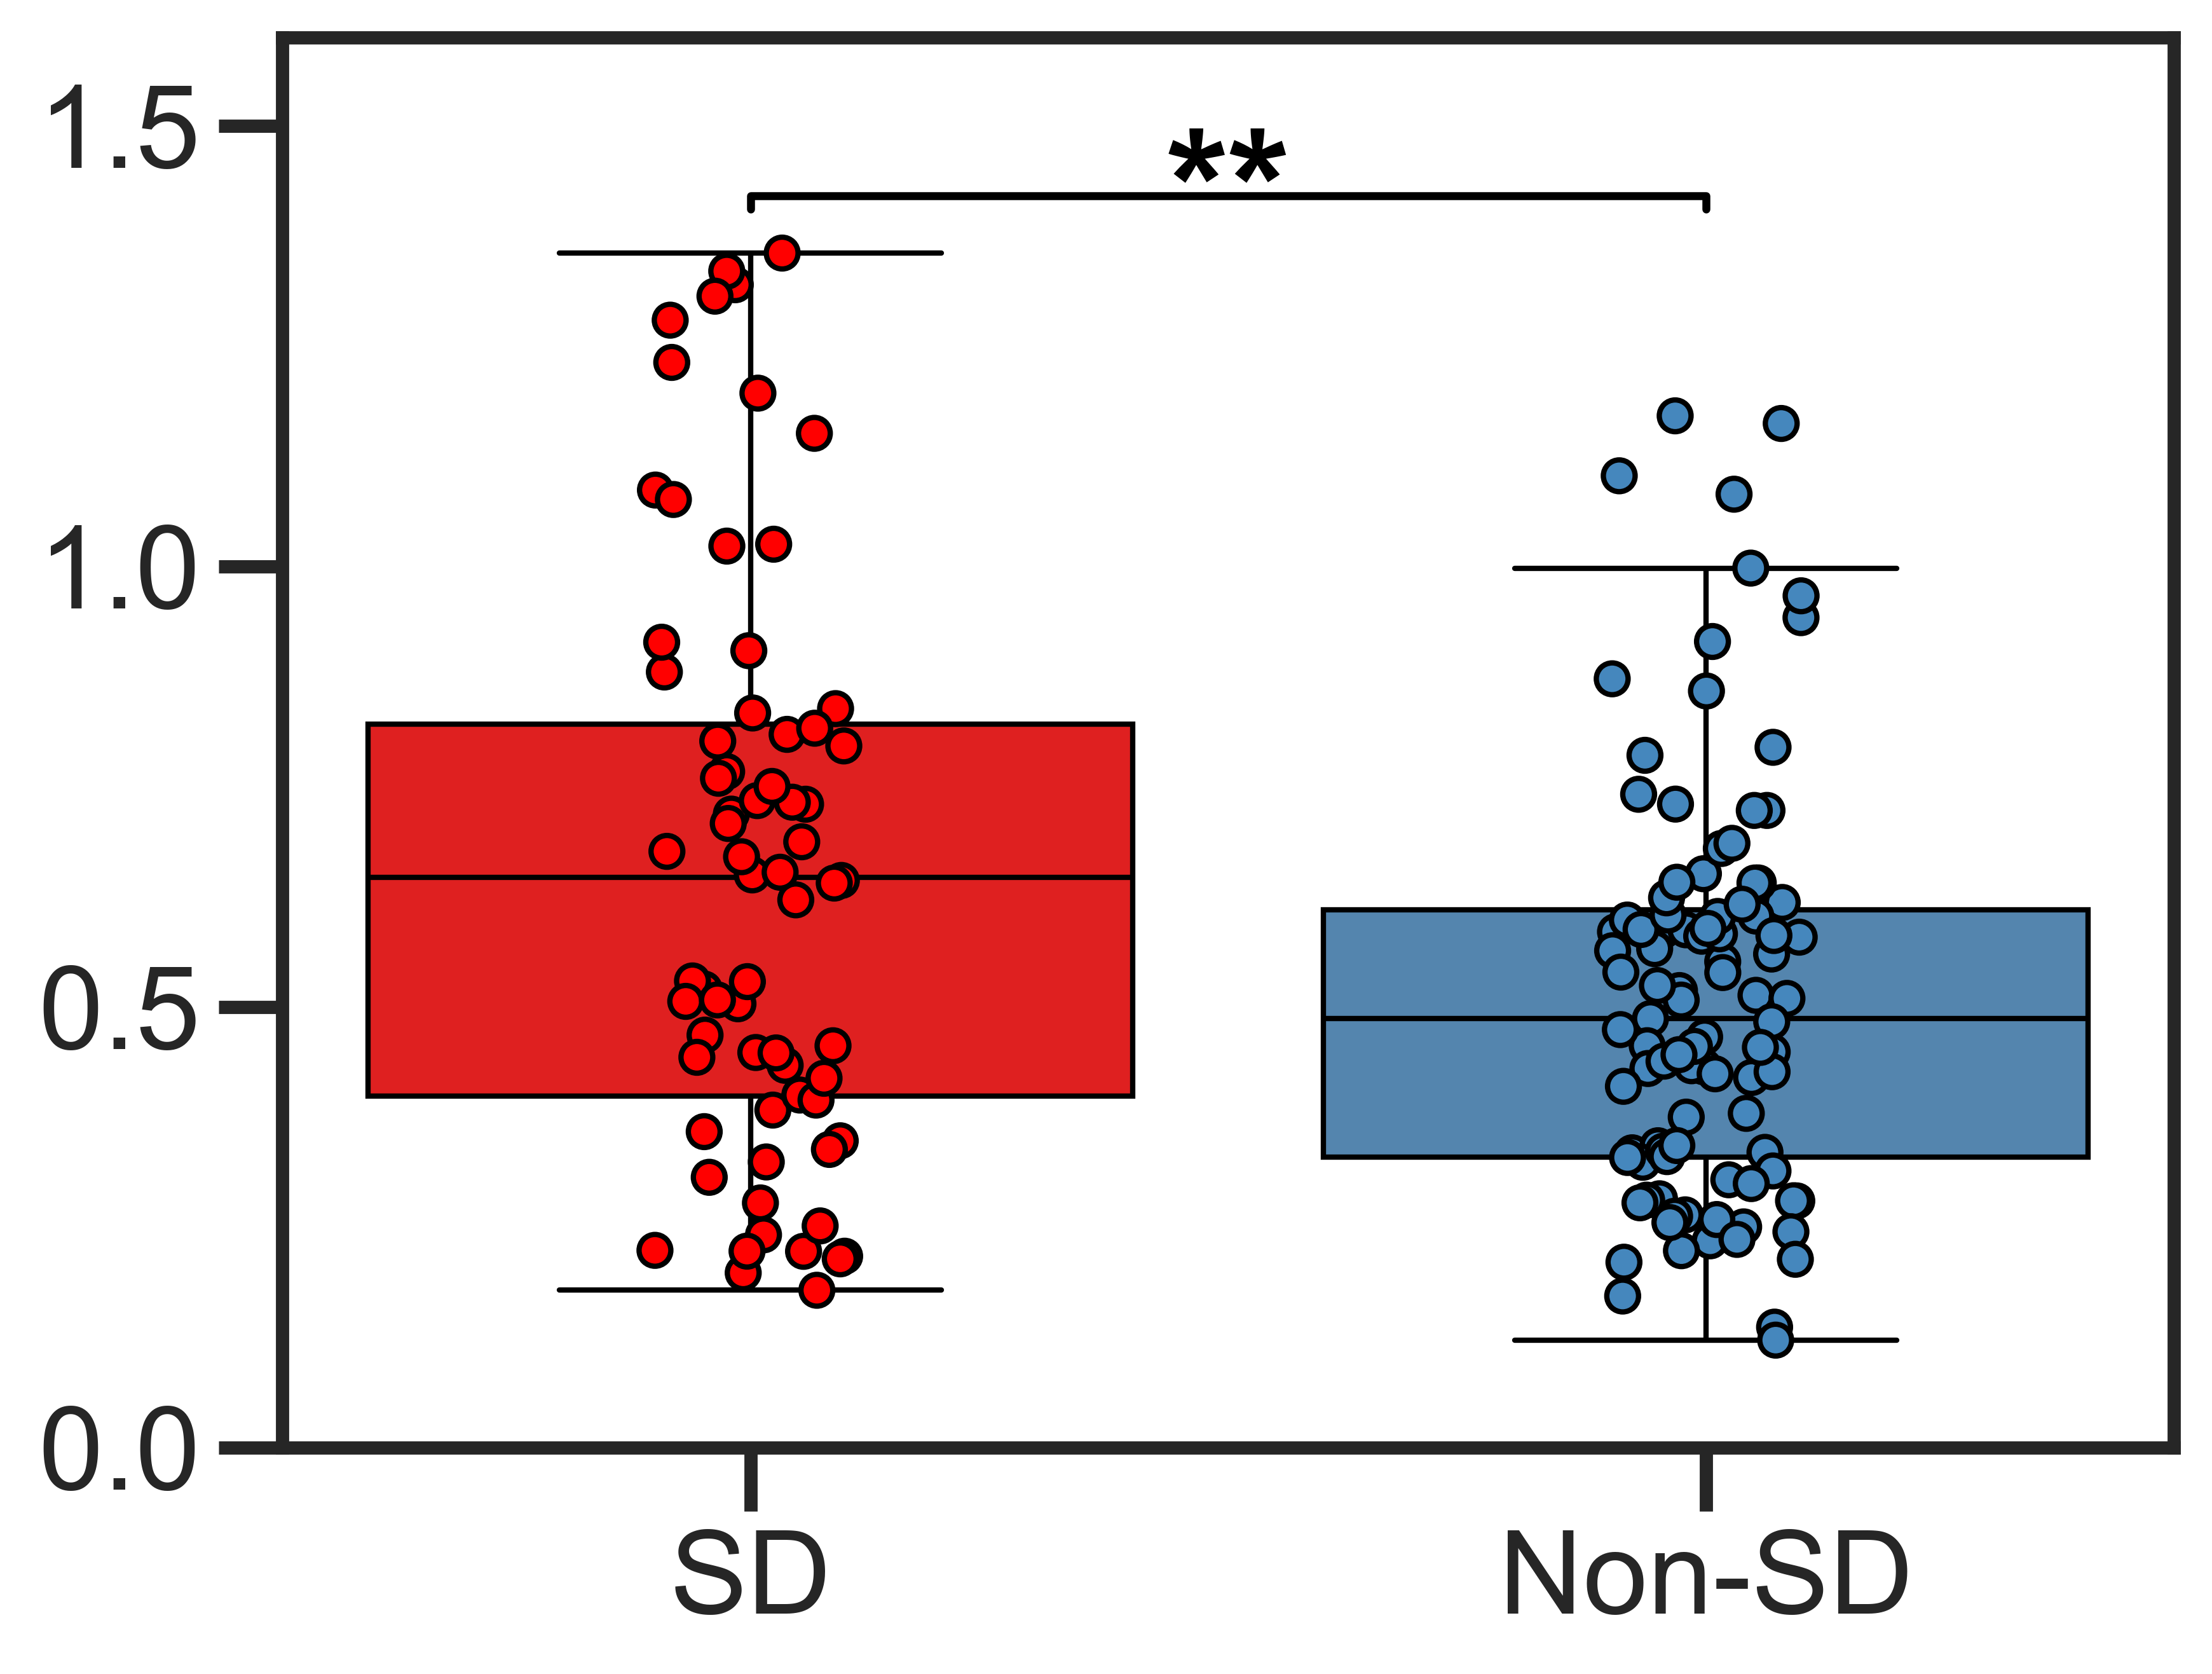

In [15]:
#PLOT PEAK PW DATA:

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

global_status_data = pd.DataFrame(global_status_data)
global_oneYear_data = pd.DataFrame(global_oneYear_data)

# Add 'Group' columns with appropriate values for each DataFrame
global_status_data['Group'] = 'SD'  # Fill entire column with 'SD'
global_oneYear_data['Group'] = 'Non-SD'  # Fill entire column with 'Non-SD'

# Concatenate the two DataFrames
combined_data = pd.concat([global_status_data[['Peak PW', 'Group']], 
                           global_oneYear_data[['Peak PW', 'Group']]])

sns.set_style("ticks")
sns.set_context("poster")

# Plot the box plot with custom colors
#plt.figure(figsize=(8, 6))
ax = sns.boxplot(
    x='Group', 
    y='Peak PW', 
    data=combined_data, 
    palette={'SD': 'red', 'Non-SD': '#4587BD'},
    showfliers=False,  # Suppress outlier points
    boxprops=dict(edgecolor='black'),  # Black outline for boxes
    whiskerprops=dict(color='black'),  # Black whiskers
    capprops=dict(color='black'),  # Black caps on whiskers
    medianprops=dict(color='black')  # Black median line
)

sns.stripplot(
    x='Group', 
    y='Peak PW', 
    data=combined_data,
    palette={'SD': 'red', 'Non-SD': '#4587BD'},
    size=6,  # Adjust size of data points
    jitter=True,  # Disable jitter for midline alignment
    alpha=1,  # Make points fully opaque
    edgecolor='black',  # Add solid black outline
    linewidth=1,  # Width of the outline
    dodge=False,  # Ensure alignment with box midline
    ax=ax
)

# Calculate mean and standard deviation for each group
means = combined_data.groupby('Group')['Peak PW'].mean()
std_devs = combined_data.groupby('Group')['Peak PW'].std()

# Add significance line and stars
x1, x2 = 0, 1  # Positions of the two groups
y, h, col = combined_data['Peak PW'].max() + 0.05, 0.015, 'black'  # Adjust height (h is smaller)
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h-0.09, "**", ha='center', va='bottom', color=col, fontsize=30, weight='bold')  # Bold text

# Customize the plot
#plt.title('Peak PW Distribution with Standard Deviation Error Bars')
#plt.xlabel('Group')
#plt.ylabel('Peak PW')
#plt.grid(axis='y', linestyle='--', alpha=0.7)
#plt.tight_layout()

plt.ylim(0,1.6)
plt.yticks(np.arange(0, 2.0, 0.5))
ax.set(xlabel=None)
ax.set(ylabel=None)

# Show the plot
plt.show()


/var/folders/qr/d2wxfs456fsf5lgfshrqbsmw0000gn/T/ipykernel_12346/1841802320.py:23: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/qr/d2wxfs456fsf5lgfshrqbsmw0000gn/T/ipykernel_12346/1841802320.py:35: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




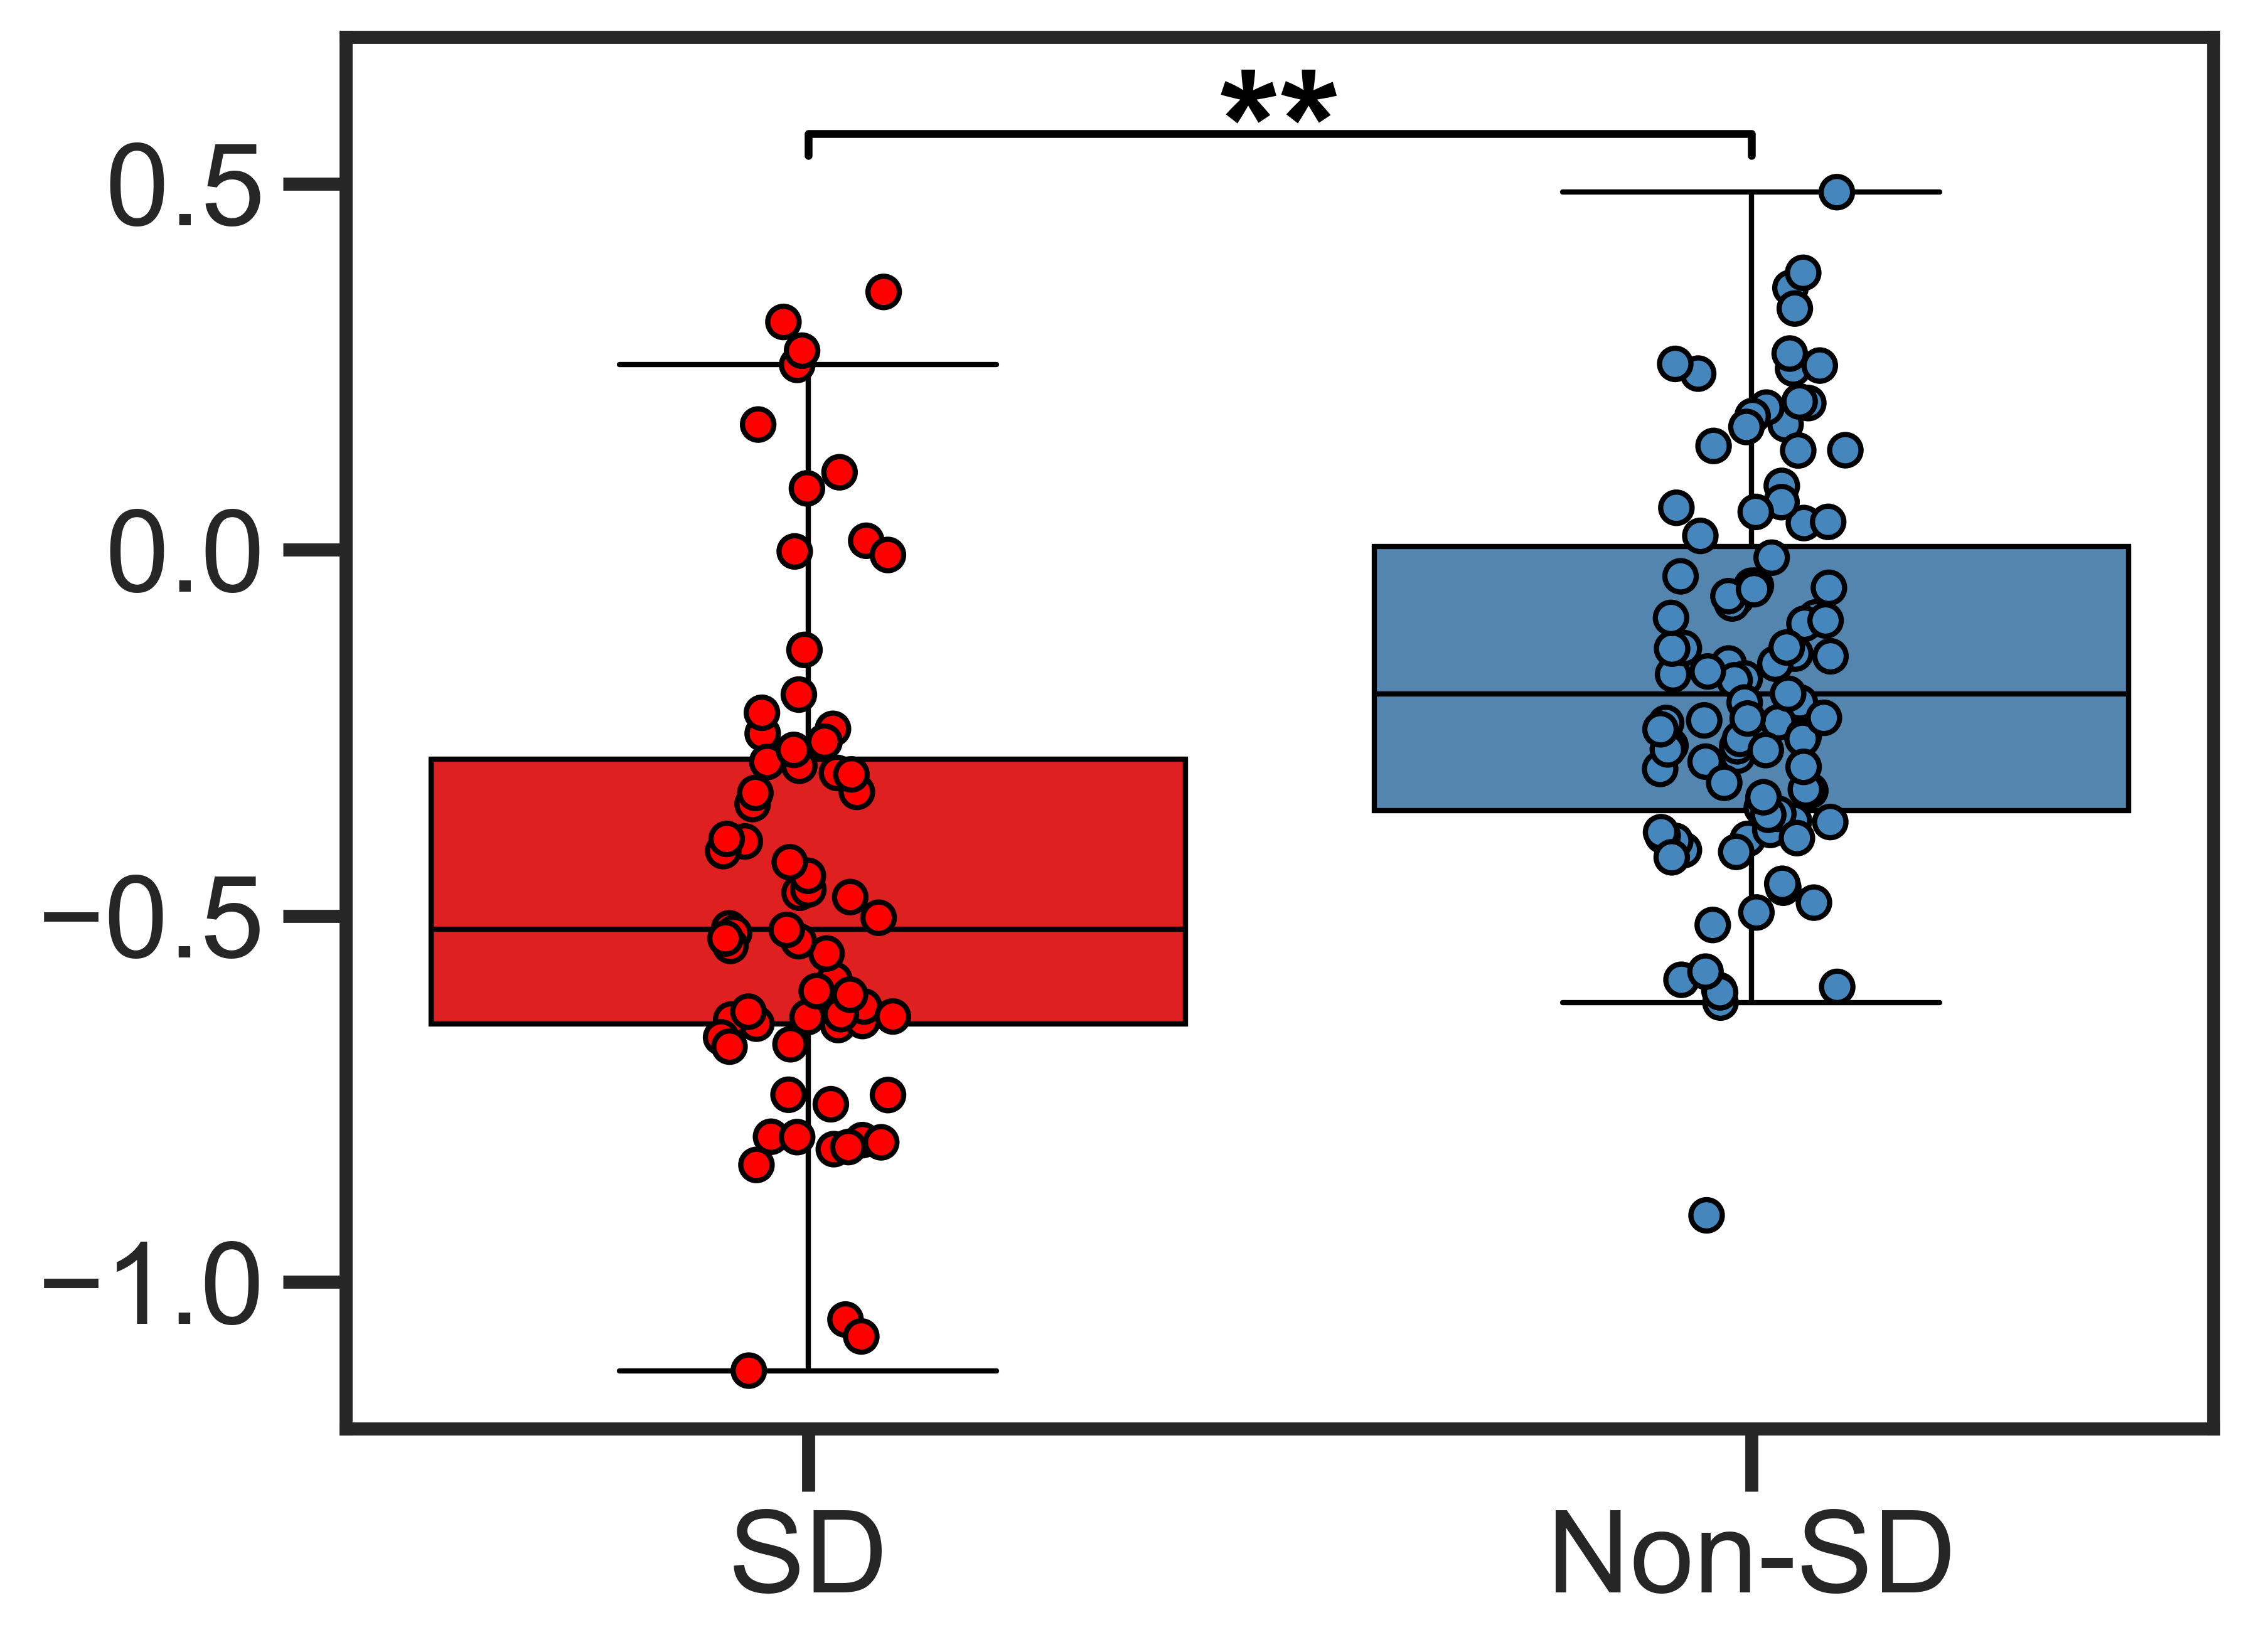

In [16]:
#PLOT APERIODIC OFFSET DATA:

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

global_status_data = pd.DataFrame(global_status_data)
global_oneYear_data = pd.DataFrame(global_oneYear_data)

# Add 'Group' columns with appropriate values for each DataFrame
global_status_data['Group'] = 'SD'  # Fill entire column with 'SD'
global_oneYear_data['Group'] = 'Non-SD'  # Fill entire column with 'Non-SD'

# Concatenate the two DataFrames
combined_data = pd.concat([global_status_data[['Aperiodic Offset', 'Group']], 
                           global_oneYear_data[['Aperiodic Offset', 'Group']]])

sns.set_style("ticks")
sns.set_context("poster")

# Plot the box plot with custom colors
#plt.figure(figsize=(8, 6))
ax = sns.boxplot(
    x='Group', 
    y='Aperiodic Offset', 
    data=combined_data,
    palette={'SD': 'red', 'Non-SD': '#4587BD'},
    showfliers=False,  # Suppress outlier points
    boxprops=dict(edgecolor='black'),  # Black outline for boxes
    whiskerprops=dict(color='black'),  # Black whiskers
    capprops=dict(color='black'),  # Black caps on whiskers
    medianprops=dict(color='black')  # Black median line
)

sns.stripplot(
    x='Group', 
    y='Aperiodic Offset', 
    data=combined_data,
    palette={'SD': 'red', 'Non-SD': '#4587BD'},
    size=6,  # Adjust size of data points
    jitter=True,  # Disable jitter for midline alignment
    alpha=1,  # Make points fully opaque
    edgecolor='black',  # Add solid black outline
    linewidth=1,  # Width of the outline
    dodge=False,  # Ensure alignment with box midline
    ax=ax
)

# Calculate mean and standard deviation for each group
means = combined_data.groupby('Group')['Aperiodic Offset'].mean()
std_devs = combined_data.groupby('Group')['Aperiodic Offset'].std()

# Add significance line and stars
x1, x2 = 0, 1  # Positions of the two groups
y, h, col = combined_data['Aperiodic Offset'].max() + 0.05, 0.03, 'black'  # Adjust height (h is smaller)
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h-0.11, "**", ha='center', va='bottom', color=col, fontsize=30, weight='bold')  # Bold text

plt.ylim(-1.2,0.7)
#plt.yticks(np.arange(0, 2.0, 0.5))
ax.set(xlabel=None)
ax.set(ylabel=None)

# Show the plot
plt.show()

/var/folders/qr/d2wxfs456fsf5lgfshrqbsmw0000gn/T/ipykernel_12346/78576224.py:23: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/qr/d2wxfs456fsf5lgfshrqbsmw0000gn/T/ipykernel_12346/78576224.py:36: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




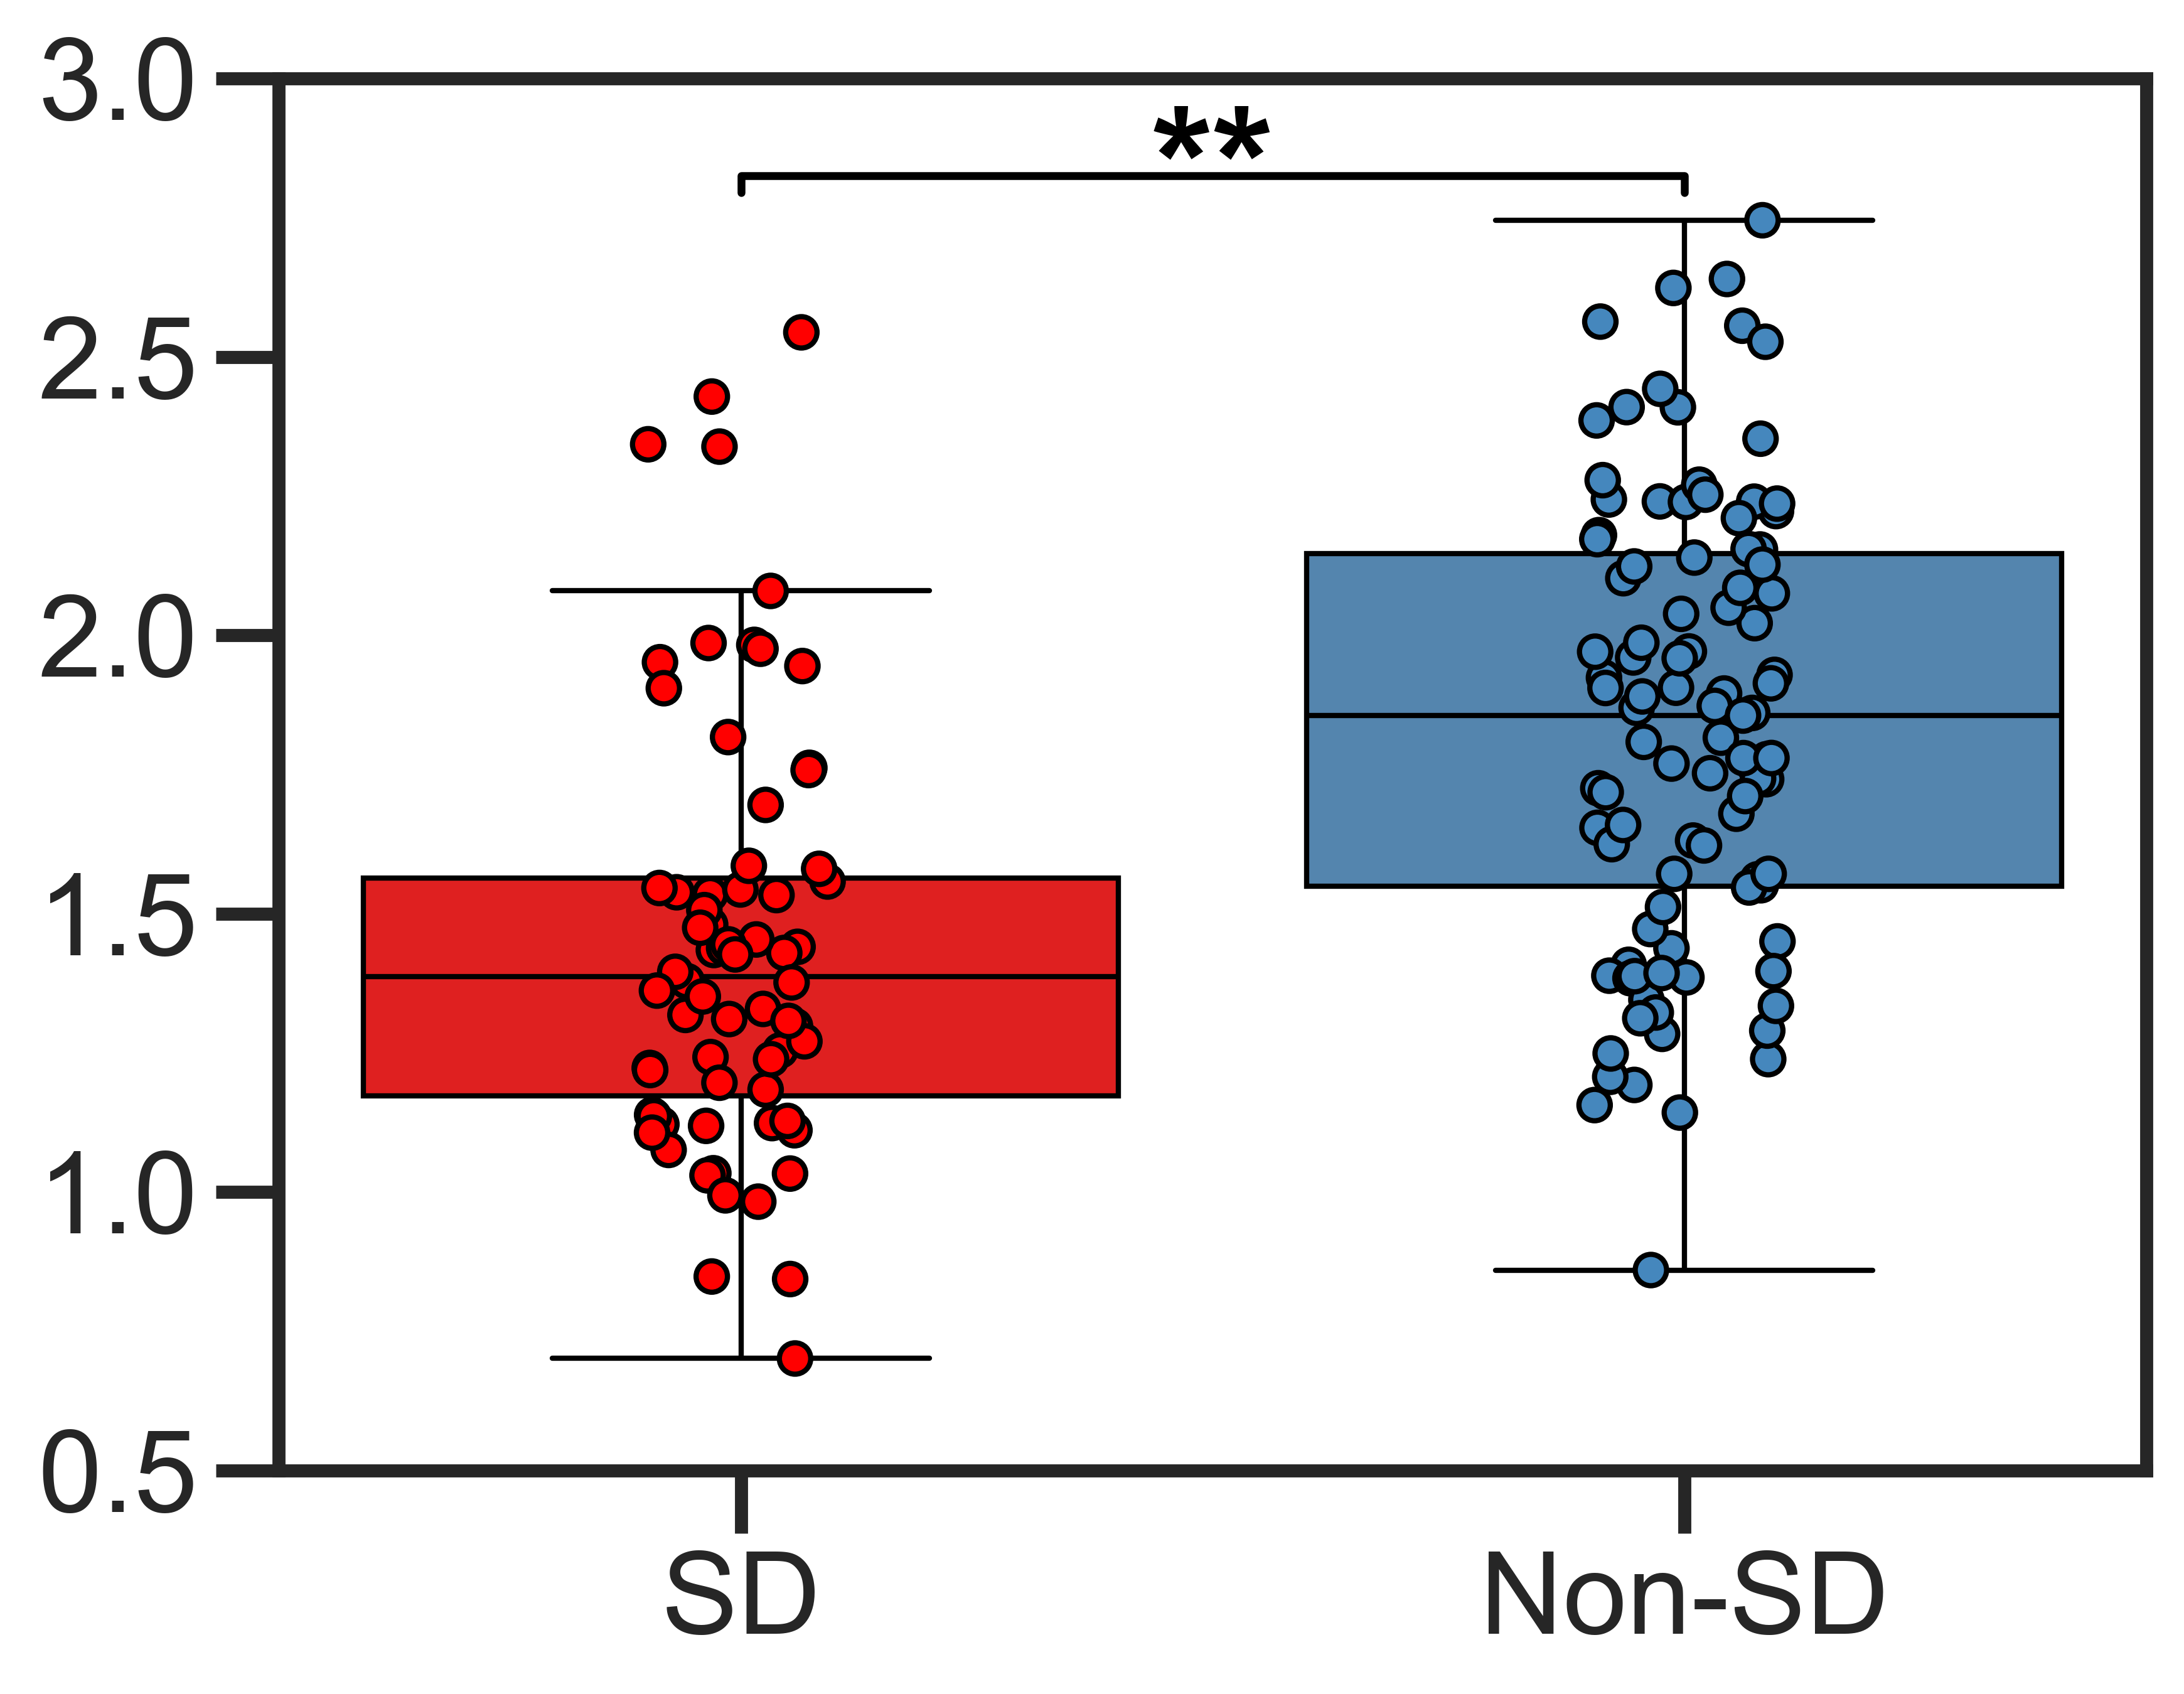

In [17]:
#PLOT APERIODIC OFFSET DATA:

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

global_status_data = pd.DataFrame(global_status_data)
global_oneYear_data = pd.DataFrame(global_oneYear_data)

# Add 'Group' columns with appropriate values for each DataFrame
global_status_data['Group'] = 'SD'  # Fill entire column with 'SD'
global_oneYear_data['Group'] = 'Non-SD'  # Fill entire column with 'Non-SD'

# Concatenate the two DataFrames
combined_data = pd.concat([global_status_data[['Aperiodic Exponent', 'Group']], 
                           global_oneYear_data[['Aperiodic Exponent', 'Group']]])

sns.set_style("ticks")
sns.set_context("poster")

# Plot the box plot with custom colors
#plt.figure(figsize=(8, 6))
ax = sns.boxplot(
    x='Group', 
    y='Aperiodic Exponent', 
    data=combined_data,
    palette={'SD': 'red', 'Non-SD': '#4587BD'},
    showfliers=False,  # Suppress outlier points
    boxprops=dict(edgecolor='black'),  # Black outline for boxes
    whiskerprops=dict(color='black'),  # Black whiskers
    capprops=dict(color='black'),  # Black caps on whiskers
    medianprops=dict(color='black')  # Black median line
)

# Overlay individual data points with stripplot
sns.stripplot(
    x='Group', 
    y='Aperiodic Exponent', 
    data=combined_data,
    palette={'SD': 'red', 'Non-SD': '#4587BD'},
    size=6,  # Adjust size of data points
    jitter=True,  # Disable jitter for midline alignment
    alpha=1,  # Make points fully opaque
    edgecolor='black',  # Add solid black outline
    linewidth=1,  # Width of the outline
    dodge=False,  # Ensure alignment with box midline
    ax=ax
)

# Calculate mean and standard deviation for each group
means = combined_data.groupby('Group')['Aperiodic Exponent'].mean()
std_devs = combined_data.groupby('Group')['Aperiodic Exponent'].std()

# Add significance line and stars
x1, x2 = 0, 1  # Positions of the two groups
y, h, col = combined_data['Aperiodic Exponent'].max() + 0.05, 0.03, 'black'  # Adjust height (h is smaller)
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h-0.135, "**", ha='center', va='bottom', color=col, fontsize=30, weight='bold')  # Bold text

plt.ylim(0.5,3)
ax.set(xlabel=None)
ax.set(ylabel=None)

# Show the plot
plt.show()

In [59]:
import pandas as pd
import plotly.graph_objects as go

# Define the significance threshold
significance_level = 0.05

# Filter to include only the columns related to Peak PW
peak_pw_columns = [
    'Patient', 'Hemisphere', 'Peak PW_status_mean', 'Peak PW_status_std', 
    'Peak PW_oneYear_mean', 'Peak PW_oneYear_std', 
    'Peak PW_p_value_ttest', 'Peak PW_t_statistic', 
    'Peak PW_p_value_mannwhitney', 'Peak PW_u_statistic'
]
peak_pw_df = all_patients_df[peak_pw_columns]
print(peak_pw_df)

# Determine which rows contain any significant p-values for Peak PW
bold_rows = (
    (peak_pw_df['Peak PW_p_value_ttest'] < significance_level) | 
    (peak_pw_df['Peak PW_p_value_mannwhitney'] < significance_level)
)

# Create a list for row font weights: 'bold' for significant rows, 'normal' otherwise
row_font_weights = ['bold' if is_bold else 'normal' for is_bold in bold_rows]

# Generate Plotly table
fig = go.Figure(data=[go.Table(
    header=dict(
        values=list(peak_pw_df.columns),
        fill_color='lightgrey',
        align='center',
        font=dict(size=12)
    ),
    cells=dict(
        values=[peak_pw_df[col] for col in peak_pw_df.columns],
        fill_color='white',
        align='center',
        font=dict(size=11, family="Arial", weight=row_font_weights)
    )
)])

# Display the table
fig.update_layout(
    title="Patient-wise Peak PW Comparison Data",
    height=600
)
fig.show()


  Patient Hemisphere  Peak PW_status_mean  Peak PW_status_std  \
0  DBS050       LEFT             0.356342            0.171585   
1  DBS021      RIGHT             0.710145            0.135452   
2  DBS003      RIGHT             0.605561            0.225527   
3  DBS013      RIGHT             0.494143            0.345867   
4  DBS039       LEFT             0.916954            0.335843   
5  DBS047       LEFT             0.386308            0.150221   
6  DBS036      RIGHT             1.258178            0.105072   

   Peak PW_oneYear_mean  Peak PW_oneYear_std  Peak PW_p_value_ttest  \
0              0.488987             0.147533               0.052569   
1              0.552928             0.034365               0.005770   
2              0.373059             0.166926               0.002506   
3              0.437537             0.287532               0.733859   
4              0.631236             0.238306               0.009513   
5              0.316379             0.145227         

In [28]:
import pandas as pd
import numpy as np
import os
import glob

phenom_df = pd.read_csv(phenomenologyFile)

# Initialize a list to store all the combined data
combined_data = []

# Criteria for hemisphere exclusion
exclude_hemisphere_conditions = [
    ('DBS003', 'LEFT'), ('DBS021', 'LEFT'), ('DBS013', 'LEFT'), ('DBS005', 'LEFT'),
    ('DBS014', 'RIGHT'), ('DBS036', 'LEFT'), ('DBS047', 'RIGHT'), 
    ('DBS050', 'RIGHT'), ('DBS039', 'RIGHT'), ('DBS018', 'RIGHT'),
    ('DBS009', 'RIGHT'), ('DBS009', 'LEFT')
]

# Iterate through each patient's peak data files in the directory
for peak_file in glob.glob(os.path.join(resultsPSDPeaksDir, "*_PSDPeaks.csv")):
    patient_peak_df = pd.read_csv(peak_file)
    
    # Extract patient identifier and hemisphere from the filename
    file_name_parts = os.path.basename(peak_file).split('_')
    patient = file_name_parts[0]
    hemisphere = file_name_parts[1]
    
    # Determine if this hemisphere should be included in the global comparison
    if (patient, hemisphere) in exclude_hemisphere_conditions:
        print(f"Skipping {hemisphere} hemisphere for patient {patient} in global comparison.")
        continue

    # Get patient details (Phenomenology, Age, and Sex)
    patient_info = phenom_df.loc[phenom_df['Patient'] == patient]
    if patient_info.empty:
        print(f"Phenomenology data not found for patient {patient}. Skipping.")
        continue
    phenomenology = patient_info['Phenomenology'].values[0]
    age = patient_info['Age'].values[0]
    sex = patient_info['Sex'].values[0]
    etiology = patient_info['Etiology'].values[0]

    # Filter data by status and oneYear
    for interval_type in ['status', 'oneYear']:
        interval_data = patient_peak_df[patient_peak_df['IntervalType'] == interval_type].copy()

        if interval_data.empty:
            print(f"No data for interval {interval_type} for patient {patient}, hemisphere {hemisphere}. Skipping.")
            continue

        # Add linear peak power, converting Peak PW to linear scale
        interval_data['Peak PW linear'] = 10 ** interval_data['Peak PW']
        
        # Add patient and additional information
        interval_data['Patient'] = patient
        interval_data['Phenomenology'] = phenomenology
        interval_data['Age'] = age
        interval_data['Sex'] = sex
        interval_data['Etiology'] = etiology
        interval_data['IntervalType'] = interval_type

        # Append the interval data to the combined data list
        combined_data.append(interval_data)

# Combine all data into a single DataFrame
combined_df = pd.concat(combined_data, ignore_index=True)

# Perform any global comparisons or further analysis using `combined_df`
print(combined_df)


Skipping LEFT hemisphere for patient DBS005 in global comparison.
Skipping RIGHT hemisphere for patient DBS039 in global comparison.
Skipping RIGHT hemisphere for patient DBS047 in global comparison.
No data for interval oneYear for patient DBS018, hemisphere LEFT. Skipping.
Skipping RIGHT hemisphere for patient DBS014 in global comparison.
Skipping RIGHT hemisphere for patient DBS009 in global comparison.
Skipping LEFT hemisphere for patient DBS036 in global comparison.
Skipping LEFT hemisphere for patient DBS003 in global comparison.
Skipping LEFT hemisphere for patient DBS013 in global comparison.
Skipping RIGHT hemisphere for patient DBS050 in global comparison.
No data for interval oneYear for patient DBS014, hemisphere LEFT. Skipping.
No data for interval oneYear for patient DBS005, hemisphere RIGHT. Skipping.
Skipping RIGHT hemisphere for patient DBS018 in global comparison.
Skipping LEFT hemisphere for patient DBS009 in global comparison.
Skipping LEFT hemisphere for patient DB

In [53]:
#GLM TO ASSESS THE EFFECT OF BENZO & OTHER SEDATING ON PEAK PW
import pandas as pd
import numpy as np
from statsmodels.formula.api import mixedlm
import os
import glob

phenom_df = pd.read_csv(phenomenologyFile)
sd_episodes_df = pd.read_csv(SD_episodesnumFile)

# Convert RecordingStartTime to datetime format
sd_episodes_df['RecordingStartTime'] = pd.to_datetime(sd_episodes_df['RecordingStartTime'])

# Initialize a list to store all the combined data
combined_data = []

# Criteria for hemisphere exclusion
exclude_hemisphere_conditions = [
    ('DBS003', 'LEFT'), ('DBS021', 'LEFT'), ('DBS013', 'LEFT'), ('DBS005', 'LEFT'),
    ('DBS014', 'RIGHT'), ('DBS036', 'LEFT'), ('DBS047', 'RIGHT'), 
    ('DBS050', 'RIGHT'), ('DBS039', 'RIGHT'), ('DBS018', 'RIGHT'),
    ('DBS009', 'RIGHT'), ('DBS009', 'LEFT')
]

# Iterate through each patient's peak data files in the directory
for peak_file in glob.glob(os.path.join(resultsPSDPeaksDir, "*_PSDPeaks.csv")):
    patient_peak_df = pd.read_csv(peak_file)
    
    # Convert RecordingStartTime in patient_peak_df to datetime and truncate seconds
    patient_peak_df['RecordingStartTime'] = pd.to_datetime(patient_peak_df['RecordingStartTime']).dt.floor('T')
    
    # Extract patient identifier and hemisphere from the filename
    file_name_parts = os.path.basename(peak_file).split('_')
    patient = file_name_parts[0]
    hemisphere = file_name_parts[1]
    
    # Determine if this hemisphere should be included in the global comparison
    if (patient, hemisphere) in exclude_hemisphere_conditions:
        print(f"Skipping {hemisphere} hemisphere for patient {patient} in global comparison.")
        continue

    # Merge patient_peak_df with sd_episodes_df to include Benzo and OtherSedating
    merged_df = pd.merge(
        patient_peak_df,
        sd_episodes_df[['Patient', 'IntervalType', 'RecordingStartTime', 'Benzo', 'OtherSedating']],
        on=['Patient', 'IntervalType', 'RecordingStartTime'],
        how='inner'
    )
    
    # Get patient details (Phenomenology, Age, and Sex)
    patient_info = phenom_df.loc[phenom_df['Patient'] == patient]
    if patient_info.empty:
        print(f"Phenomenology data not found for patient {patient}. Skipping.")
        continue
    phenomenology = patient_info['Phenomenology'].values[0]
    age = patient_info['Age'].values[0]
    sex = patient_info['Sex'].values[0]
    etiology = patient_info['Etiology'].values[0]

    # Add patient and additional information to merged_df
    merged_df['Phenomenology'] = phenomenology
    merged_df['Age'] = age
    merged_df['Sex'] = sex
    merged_df['Etiology'] = etiology

    # Append the interval data to the combined data list
    combined_data.append(merged_df)

# Combine all data into a single DataFrame
combined_df = pd.concat(combined_data, ignore_index=True)

# Drop rows with missing data in Benzo, OtherSedating, or Peak PW
model_data = combined_df[['Patient', 'Benzo', 'OtherSedating', 'Peak PW']].dropna()

# Encode Benzo and OtherSedating as binary variables (Y = 1, N = 0)
model_data['Benzo'] = model_data['Benzo'].map({'Y': 1, 'N': 0})
model_data['OtherSedating'] = model_data['OtherSedating'].map({'Y': 1, 'N': 0})

#add a new column all_sedating that is a combination of Benzo and OtherSedating, with value 1 if either is 1 and 0 otherwise
model_data['AllSedating'] = model_data['Benzo'] | model_data['OtherSedating']

# Fit the linear mixed-effects model
model = mixedlm(
    "Q('Peak PW') ~ Benzo",  # Benzo and OtherSedating as fixed effects
    data=model_data,
    groups=model_data['Patient'],  # Random effect for Patient
    re_formula="~Benzo"  # Random slope as well
)
result = model.fit()
print(result.summary())

# Fit the linear mixed-effects model
model = mixedlm(
    "Q('Peak PW') ~ OtherSedating",  # Benzo and OtherSedating as fixed effects
    data=model_data,
    groups=model_data['Patient'],  # Random effect for Patient
    re_formula="~OtherSedating"  # Random slope as well
)
result = model.fit()
print(result.summary())

# Fit the linear mixed-effects model
model = mixedlm(
    "Q('Peak PW') ~ AllSedating",  # Benzo and OtherSedating as fixed effects
    data=model_data,
    groups=model_data['Patient'],  # Random effect for Patient
    re_formula="~AllSedating"  # Random slope too
)
result = model.fit()

# Print the summary
print(result.summary())


/var/folders/qr/d2wxfs456fsf5lgfshrqbsmw0000gn/T/ipykernel_12346/1985322130.py:30: FutureWarning:

'T' is deprecated and will be removed in a future version, please use 'min' instead.

/var/folders/qr/d2wxfs456fsf5lgfshrqbsmw0000gn/T/ipykernel_12346/1985322130.py:30: FutureWarning:

'T' is deprecated and will be removed in a future version, please use 'min' instead.

/var/folders/qr/d2wxfs456fsf5lgfshrqbsmw0000gn/T/ipykernel_12346/1985322130.py:30: FutureWarning:

'T' is deprecated and will be removed in a future version, please use 'min' instead.

/var/folders/qr/d2wxfs456fsf5lgfshrqbsmw0000gn/T/ipykernel_12346/1985322130.py:30: FutureWarning:

'T' is deprecated and will be removed in a future version, please use 'min' instead.

/var/folders/qr/d2wxfs456fsf5lgfshrqbsmw0000gn/T/ipykernel_12346/1985322130.py:30: FutureWarning:

'T' is deprecated and will be removed in a future version, please use 'min' instead.

/var/folders/qr/d2wxfs456fsf5lgfshrqbsmw0000gn/T/ipykernel_12346/1985322130

Skipping LEFT hemisphere for patient DBS005 in global comparison.
Skipping RIGHT hemisphere for patient DBS039 in global comparison.
Skipping RIGHT hemisphere for patient DBS047 in global comparison.
Skipping RIGHT hemisphere for patient DBS014 in global comparison.
Skipping RIGHT hemisphere for patient DBS009 in global comparison.
Skipping LEFT hemisphere for patient DBS036 in global comparison.
Skipping LEFT hemisphere for patient DBS003 in global comparison.
Skipping LEFT hemisphere for patient DBS013 in global comparison.
Skipping RIGHT hemisphere for patient DBS050 in global comparison.
Skipping RIGHT hemisphere for patient DBS018 in global comparison.
Skipping LEFT hemisphere for patient DBS009 in global comparison.
Skipping LEFT hemisphere for patient DBS021 in global comparison.
          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Q('Peak PW')
No. Observations: 177     Method:             REML        
No. Groups:       10      Scale:    

'\n# Extract the summary statistics\npeak_pw_results = {\n    \'Benzo_coef\': result.params[\'Benzo\'],  # Effect size for Benzo\n    \'Benzo_p_value\': result.pvalues[\'Benzo\'],  # P-value for Benzo\n    \'Benzo_ci_lower\': result.conf_int().loc[\'Benzo\', 0],  # Lower bound of 95% CI for Benzo\n    \'Benzo_ci_upper\': result.conf_int().loc[\'Benzo\', 1],  # Upper bound of 95% CI for Benzo\n    \'OtherSedating_coef\': result.params[\'OtherSedating\'],  # Effect size for OtherSedating\n    \'OtherSedating_p_value\': result.pvalues[\'OtherSedating\'],  # P-value for OtherSedating\n    \'OtherSedating_ci_lower\': result.conf_int().loc[\'OtherSedating\', 0],  # Lower bound of 95% CI for OtherSedating\n    \'OtherSedating_ci_upper\': result.conf_int().loc[\'OtherSedating\', 1],  # Upper bound of 95% CI for OtherSedating\n}\n\n# Create a DataFrame for better display\npeak_pw_results_df = pd.DataFrame([peak_pw_results], index=[\'Peak PW\'])\n\n# Display the final results\nprint("\nFinal Res

In [87]:
from pymer4.models import Lmer
from pymer4.stats import rsquared, lrt

combined_df['PeakPW'] = combined_df['Peak PW']

model = Lmer("PeakPW ~ IntervalType + (1|Patient)", 
             data=combined_df)
result = model.fit()
print(result)

model = Lmer("PeakPW ~ Phenomenology + (1|Patient)", 
             data=combined_df)
result = model.fit()
print(result)

model = Lmer("PeakPW ~ Age + (1|Patient)", 
             data=combined_df)
result = model.fit()
print(result)

model = Lmer("PeakPW ~ Sex + (1|Patient)", 
             data=combined_df)
result = model.fit()
print(result)

model = Lmer("PeakPW ~ Etiology + (1|Patient)", 
             data=combined_df)
result = model.fit()
print(result)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pymer4/models/Lmer.py:733: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pymer4/models/Lmer.py:733: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



Linear mixed model fit by REML [’lmerMod’]
Formula: PeakPW~IntervalType+(1|Patient)

Family: gaussian	 Inference: parametric

Number of observations: 183	 Groups: {'Patient': 10.0}

Log-likelihood: 1.480 	 AIC: 5.040

Random effects:

                 Name    Var    Std
Patient   (Intercept)  0.039  0.199
Residual               0.048  0.220

No random effect correlations specified

Fixed effects:

                    Estimate  2.5_ci  97.5_ci     SE       DF  T-stat  P-val  \
(Intercept)            0.480   0.342    0.617  0.070   10.438   6.856    0.0   
IntervalTypestatus     0.157   0.084    0.229  0.037  178.847   4.244    0.0   

                    Sig  
(Intercept)         ***  
IntervalTypestatus  ***  
Linear mixed model fit by REML [’lmerMod’]
Formula: PeakPW~Phenomenology+(1|Patient)

Family: gaussian	 Inference: parametric

Number of observations: 183	 Groups: {'Patient': 10.0}

Log-likelihood: -4.850 	 AIC: 17.701

Random effects:

                 Name    Var    Std
Patien

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pymer4/models/Lmer.py:733: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pymer4/models/Lmer.py:733: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



Linear mixed model fit by REML [’lmerMod’]
Formula: PeakPW~Age+(1|Patient)

Family: gaussian	 Inference: parametric

Number of observations: 183	 Groups: {'Patient': 10.0}

Log-likelihood: -7.760 	 AIC: 23.521

Random effects:

                 Name    Var    Std
Patient   (Intercept)  0.039  0.198
Residual               0.053  0.231

No random effect correlations specified

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE     DF  T-stat  P-val Sig
(Intercept)     0.650   0.331    0.969  0.163  7.227   3.994  0.005  **
Age            -0.009  -0.041    0.023  0.017  7.318  -0.545  0.602    
Linear mixed model fit by REML [’lmerMod’]
Formula: PeakPW~Sex+(1|Patient)

Family: gaussian	 Inference: parametric

Number of observations: 183	 Groups: {'Patient': 10.0}

Log-likelihood: -5.501 	 AIC: 19.001

Random effects:

                 Name    Var    Std
Patient   (Intercept)  0.037  0.193
Residual               0.053  0.231

No random effect correlations specified

Fixed effect

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pymer4/models/Lmer.py:733: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.

